In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_86038/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# IMPORT
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit
import pandas as pd


@jit()
def rms(true,prediction):
    return np.sqrt(np.nanmean((prediction-true)**2))

@jit()
def rms_tendency(variable,hours):
    variable_tendency = np.zeros((hours))
    variable = np.exp(variable) * 1000.0
    for i in range(hours):
        variable_tendency[i] = np.sqrt(np.mean((variable[i+1] - variable[i])**2.0))
    return variable_tendency

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true
    weights = np.cos(np.deg2rad(lats))
    weights2d = np.zeros(np.shape(diff))
    
    diff_squared = diff**2.0
#     print('shape of diff_squared raw ', np.shape(diff_squared))
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
#     print('shape of masked ', np.shape(masked))
    weighted_average = np.ma.average(masked,weights=weights2d)
    return np.sqrt(weighted_average)


In [8]:
def surf_pressure_rmse(time_period,variable_speedy):
    #     time_period = 0
#     variable_speedy = 't'
#     level_in_speedy = 0.95 #0.2#0.95#0.51
    #     level_era = 7 #2#7 #4


    # Define: Initial FILES, dates, Variable, and Level desired

    ## FORECAST FILES NOW = 

    #1_9_1_9; trained on speedy 1.9, then those weights generated another 29 year analysis of 1.9, then trained on that
    hybrid_2nd_iteration_forecast_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/forecast_files_dylan/hybrid_1_9_1_9_prediction_1_7_2011010700_2011011700.nc'
    #hybrid prediction from grace
    #'/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/forecast_files_dylan/hybrid_prediction_era6000_20_20_20_beta_res1.0_beta_model_0.01_prior_0.0_overlap1_vertlevel_1_era5_uniform_29yr_training_cov_1_9_1_9_hybridtrial_01_05_2011_01.nc'

    speedy_1_9_forecast_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/forecast_files_dylan/speedy_1_9_001_forecasts_2011010700_2011011706.nc'
    #ONLY 3 days
    #'/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/forecast_files_dylan/speedy_1_9_001_forecasts_2011010700_2011011006.nc'

    era5_persistence_file = '/skydata2/troyarcomano/ERA_5/2011/era_5_y2011_regridded_mpi_fixed_var.nc'
    
    trained_on_era5_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/forecast_files_dylan/era5_trained_hybrid_1_9_001_forecasts_2011010700_2011011706.nc'
    
    hybrid_1st_iteration_forecast_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/forecast_files_dylan/hybrid_1_9_1st_iter_001_forecasts_2011010700_2011011712.nc'
    

    ### LOAD TIME and variable

    start_year = 2011
    end_year = 2011
    startdate = datetime(2011,1,7,0)
    # enddate = datetime(2011,1,10,0)
    # time_slice = slice(startdate,enddate)

    prediction_start_timestep_number = (6*4)#  START AT 2011 01 07 00 == 6 days * 4 timesteps perday!!
    # make time dynamic
    timestep_interval = 6
    days = time_period // 24
    print('days ', days)
    hours = (time_period % 24) #+ timestep_interval 
    print('hours ', hours)
    
    selected_date = startdate + timedelta(days=days, hours=hours)
    selected_timestep_from_jan1 = prediction_start_timestep_number + (((days * 24) + hours) // 6)
    
    print(f"Selected Date: {selected_date}")
    print(f"Selected Timestep from Jan 1: {selected_timestep_from_jan1}")
    # Works!  
        
    # level = 0.95 #0.2#0.95#0.51
    # level_era = 7 #2#7 #4

#     level = level_in_speedy
#     if level_in_speedy == .95:
#         level_in_era = 7
#     if level_in_speedy == .835:
#         level_in_era = 6
#     if level_in_speedy == .685:
#         level_in_era = 5
#     if level_in_speedy == .51:
#         level_in_era = 4
#     if level_in_speedy == .34:
#         level_in_era = 3
#     if level_in_speedy == .2:
#         level_in_era = 2
#     if level_in_speedy == .095:
#         level_in_era = 1
#     if level_in_speedy == .025:
#         level_in_era = 0
#     #     print(level_in_era)    
#     level_era = level_in_era

    var_da = variable_speedy


    if variable_speedy == 'q':
        variable_era = 'Specific_Humidity'
        var_hybrid_prediction = 'Specific-Humidity'
    if variable_speedy == 't':
        variable_era = 'Temperature'
    if variable_speedy == 'v':
        variable_era = 'V-wind'
    if variable_speedy == 'u':
        variable_era = 'U-wind'
    #     var_era = variable_era
    print(variable_era)
    var_era = variable_era

    #var_era = 'V-wind'#'Specific_Humidity'#'Temperature' #'V-wind'
    #var_da =  'v'#'q'#'t'#'v'
    print('you selected for variable =',var_era)
#     print('at level =',level)

    # LOAD ERA5 climate  ---- STATIC timeperiod
    timestep_6hrly = 6
    climate_start_year = 1981
    climate_end_year = 2009
    start_timestep_index_for_each_year = prediction_start_timestep_number # start 7th day
    end_timestep_index_for_each_year = (16*4) # end 17th
    climate_slice_2ndweek = slice(start_timestep_index_for_each_year, end_timestep_index_for_each_year)

    # create empty list to store individual datasets
    era5sets = []
    print('made it to the for loop...')

    # LOAD DATA HERE 
    print('LOADING DATA...')

    # loop over the range of years and open each ds
    for year in range(climate_start_year, climate_end_year + 1):
        nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
        ds_era5_all_28_years = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)

        # Read in every 6th timestep
        ds_era5_all_28_years = ds_era5_all_28_years.isel(Timestep=slice(None, None, timestep_6hrly))
#         print('ds_era5_all_28_years shape ', np.shape(ds_era5_all_28_years))
        # Select data for the specified date range
        ds_week = ds_era5_all_28_years.sel(Timestep=climate_slice_2ndweek)
#         print('ds_week shape ', np.shape(ds_week))
    #     print('year ', year, 'dims ', ds_week.dims)
    #     print('summary ', ds_week)
#         print('era5sets shape', np.shape(era5sets))
        era5sets.append(ds_week)

    print('Now its concatenating them all together...')

    ds_era5_all_weeks = xr.concat(era5sets, dim='Timestep')
    print('shape era5 all weeks CONCAT', np.shape(ds_era5_all_weeks))
    ds_era5_all_weeks = ds_era5_all_weeks.sortby('Timestep')
    print('shape era5 all weeks SORTBY', np.shape(ds_era5_all_weeks))
    print('Done concat and sort by Timestep era5 climate...')


    # take average at each grid point  
    print('shape here', np.shape(ds_era5_all_weeks) )
    era5_climate = np.mean(ds_era5_all_weeks,axis = 0)
    print('era5_climate shape', np.shape(era5_climate))
    # print(era5_climate)

    # static at 2011010700
    ds_era5_persistence = xr.open_dataset(era5_persistence_file)[var_era].sel(Sigma_Level=level_era)
    ds_era5_persistence = ds_era5_persistence.isel(Timestep=slice(None,None,timestep_6hrly))
    Timestep_2011010700 = prediction_start_timestep_number
    ds_era5_persistence = ds_era5_persistence.isel(Timestep = Timestep_2011010700)
    
    # SPEEDY ANALYSIS Persistence 
    ds_speedy_1_9_persistence = xr.open_dataset(speedy_1_9_forecast_file)[var_da].sel(lev=level,time=startdate).values # Static at startdate
    # ---

    # call forecast and era5 reanal at time_period prescribed


    ## DEFINE NEW FORECAST XARRAYS

    #     ds_hybrid_2nd_iteration_forecast = xr.open_dataset(hybrid_2nd_iteration_forecast_file)
    #     print(ds_hybrid_2nd_iteration_forecast)
    ## IF HYBRID PREDICTION FROM GRACE ___ USE BELOW
    # if var_da == 'q':
    #     ds_hybrid_2nd_iteration_forecast = xr.open_dataset(hybrid_2nd_iteration_forecast_file)[var_hybrid_prediction].sel(Sigma_Level=level_era)
    #     ds_hybrid_2nd_iteration_forecast = ds_hybrid_2nd_iteration_forecast.sel(Timestep = selected_hybrid_Timestep)
    # else:
    #     ds_hybrid_2nd_iteration_forecast = xr.open_dataset(hybrid_2nd_iteration_forecast_file)[var_era].sel(Sigma_Level=level_era, Timestep = selected_hybrid_Timestep)
    # HYBRID COULD BE ACTUALLY 1 behind, not 100% sure if initial conditions count as timestep 1 or if thats prediction 1

    ds_speedy_1_9_forecast = xr.open_dataset(speedy_1_9_forecast_file)[var_da].sel(lev=level,time=selected_date).values # time = selected_date
    # HYBRID PREDICT FROM LETKF HERE
    ds_hybrid_2nd_iteration_forecast = xr.open_dataset(hybrid_2nd_iteration_forecast_file)[var_da].sel(lev=level,time=selected_date).values
    
    ds_trained_on_era5_1_9 = xr.open_dataset(trained_on_era5_file)[var_da].sel(lev=level,time=selected_date).values
    
    ds_hybrid_1st_iteration_forecast = xr.open_dataset(hybrid_1st_iteration_forecast_file)[var_da].sel(lev=level,time=selected_date).values

    #     print('shape check speedy ', np.shape(ds_speedy_1_9_forecast))
    #     print('data speedy ', ds_speedy_1_9_forecast)
    #     print('data speedy values ', ds_speedy_1_9_forecast.values)
    #     print('shape check hybrid ', np.shape(ds_hybrid_2nd_iteration_forecast))

    # load TRUTH DATA, as 6hrly..
    ds_era5_verification_data = xr.open_dataset(era5_persistence_file)[var_era].sel(Sigma_Level=level_era)
    ds_era5_verification_data = ds_era5_verification_data.isel(Timestep=slice(None,None,timestep_6hrly))
    ds_era5_verification_data = ds_era5_verification_data.sel(Timestep = selected_timestep_from_jan1)

    #     print("ds_era5_verification data sahpe ", np.shape(ds_era5_verification_data))
    xgrid = 96
    ygrid = 48
    #length =365*4*2 #1952-7 # 240 for 3 months  #1450 ##338 #160#64#177#1400#455

    # define globals to be added to list of veritcal profiles rmse's

    global forecast_hybrid_rmse
    global forecast_speedy_rmse
    global persistence_rmse
    global climate_rmse
    global speedy_persistence_rmse
    global forecast_era5_trained_rmse
    global forecast_hybrid_1st_iter_rmse

    forecast_hybrid_rmse = np.zeros(1)
    #     print(' forecast_hybrid_rmse ', forecast_hybrid_rmse)
    forecast_speedy_rmse = np.zeros((1))
    #     print('forecast_speedy_rmse ', forecast_speedy_rmse)
    persistence_rmse = np.zeros(1)
    climate_rmse = np.zeros(1)
    speedy_persistence_rmse = np.zeros(1)
    forecast_era5_trained_rmse = np.zeros(1)
    forecast_hybrid_1st_iter_rmse = np.zeros(1)

    lats = ds_era5_verification_data.Lat

    #     print('forecast_hybridrmse , ds_era5_verification_data, ds_hybrid2nditerforecast ', np.shape(forecast_hybrid_rmse), \
    #          np.shape(ds_era5_verification_data), np.shape(ds_hybrid_2nd_iteration_forecast))
    #     print('forecast_speedy_rmse , ds_era5verifcationdata, ds_speedy_1_9_forecast ', np.shape(forecast_speedy_rmse), \
    #          np.shape(ds_era5_verification_data), np.shape(ds_speedy_1_9_forecast))

    #calc rmse
    forecast_hybrid_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],ds_hybrid_2nd_iteration_forecast[:,:],lats)
    persistence_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],ds_era5_persistence[:,:],lats)
    climate_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],era5_climate[:,:],lats)
    forecast_speedy_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],ds_speedy_1_9_forecast[:,:],lats)
    speedy_persistence_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],ds_speedy_1_9_persistence[:,:],lats)
    forecast_era5_trained_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],ds_trained_on_era5_1_9[:,:],lats)
    forecast_hybrid_1st_iter_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],ds_hybrid_1st_iteration_forecast[:,:],lats)


    print('Done with cell')

[  0   6  12  18  24  30  36  42  48  54  60  66  72  78  84  90  96 102
 108 114 120 126 132 138 144 150 156 162 168 174 180 186 192 198 204 210
 216 222 228 234 240]


In [15]:
# Main function

def take_rmse_at_time_period_at_level_of_variable(time_period,level_in_speedy,variable_speedy):
#     time_period = 0
#     variable_speedy = 't'
#     level_in_speedy = 0.95 #0.2#0.95#0.51
    #     level_era = 7 #2#7 #4


    # Define: Initial FILES, dates, Variable, and Level desired

    ## FORECAST FILES NOW = 

    #1_9_1_9; trained on speedy 1.9, then those weights generated another 29 year analysis of 1.9, then trained on that
    hybrid_2nd_iteration_forecast_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/forecast_files_dylan/hybrid_1_9_1_9_prediction_1_7_2011010700_2011011700.nc'
    #hybrid prediction from grace
    #'/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/forecast_files_dylan/hybrid_prediction_era6000_20_20_20_beta_res1.0_beta_model_0.01_prior_0.0_overlap1_vertlevel_1_era5_uniform_29yr_training_cov_1_9_1_9_hybridtrial_01_05_2011_01.nc'

    speedy_1_9_forecast_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/forecast_files_dylan/speedy_1_9_001_forecasts_2011010700_2011011706.nc'
    #ONLY 3 days
    #'/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/forecast_files_dylan/speedy_1_9_001_forecasts_2011010700_2011011006.nc'

    era5_persistence_file = '/skydata2/troyarcomano/ERA_5/2011/era_5_y2011_regridded_mpi_fixed_var.nc'
    
    trained_on_era5_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/forecast_files_dylan/era5_trained_hybrid_1_9_001_forecasts_2011010700_2011011706.nc'
    
    hybrid_1st_iteration_forecast_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/forecast_files_dylan/hybrid_1_9_1st_iter_001_forecasts_2011010700_2011011712.nc'
    

    ### LOAD TIME and variable

    start_year = 2011
    end_year = 2011
    startdate = datetime(2011,1,7,0)
    # enddate = datetime(2011,1,10,0)
    # time_slice = slice(startdate,enddate)

    prediction_start_timestep_number = (6*4)#  START AT 2011 01 07 00 == 6 days * 4 timesteps perday!!
    # make time dynamic
    timestep_interval = 6
    days = int(time_period // 24)
    print('days ', days)
    hours = int(time_period % 24) #+ timestep_interval 
    print('hours ', hours)
    
    selected_date = startdate + timedelta(days=days, hours=hours)
    selected_timestep_from_jan1 = prediction_start_timestep_number + (((days * 24) + hours) // 6)
    
    print(f"Selected Date: {selected_date}")
    print(f"Selected Timestep from Jan 1: {selected_timestep_from_jan1}")
    # Works!  
        
    # level = 0.95 #0.2#0.95#0.51
    # level_era = 7 #2#7 #4

    level = level_in_speedy
    if level_in_speedy == .95:
        level_in_era = 7
    if level_in_speedy == .835:
        level_in_era = 6
    if level_in_speedy == .685:
        level_in_era = 5
    if level_in_speedy == .51:
        level_in_era = 4
    if level_in_speedy == .34:
        level_in_era = 3
    if level_in_speedy == .2:
        level_in_era = 2
    if level_in_speedy == .095:
        level_in_era = 1
    if level_in_speedy == .025:
        level_in_era = 0
    #     print(level_in_era)    
    level_era = level_in_era

    var_da = variable_speedy


    if variable_speedy == 'q':
        variable_era = 'Specific_Humidity'
        var_hybrid_prediction = 'Specific-Humidity'
    if variable_speedy == 't':
        variable_era = 'Temperature'
    if variable_speedy == 'v':
        variable_era = 'V-wind'
    if variable_speedy == 'u':
        variable_era = 'U-wind'
    if variable_speedy == 'ps':
        variable_era = 'logp'
    #     var_era = variable_era
    print(variable_era)
    var_era = variable_era

    #var_era = 'V-wind'#'Specific_Humidity'#'Temperature' #'V-wind'
    #var_da =  'v'#'q'#'t'#'v'
    print('you selected for variable =',var_era)
    print('at level =',level)

    # LOAD ERA5 climate  ---- STATIC timeperiod
    timestep_6hrly = 6
    climate_start_year = 1981
    climate_end_year = 2009
    start_timestep_index_for_each_year = prediction_start_timestep_number # start 7th day
    end_timestep_index_for_each_year = (16*4) # end 17th
    climate_slice_2ndweek = slice(start_timestep_index_for_each_year, end_timestep_index_for_each_year)

    # create empty list to store individual datasets
    era5sets = []
    print('made it to the for loop...')

    # LOAD DATA HERE 
    print('LOADING DATA...')

    # loop over the range of years and open each ds
    for year in range(climate_start_year, climate_end_year + 1):
        nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
        if variable_speedy == 'ps':
            ds_era5_all_28_years = xr.open_dataset(nature_file)[var_era]
        else:
            ds_era5_all_28_years = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)

        # Read in every 6th timestep
        ds_era5_all_28_years = ds_era5_all_28_years.isel(Timestep=slice(None, None, timestep_6hrly))
#         print('ds_era5_all_28_years shape ', np.shape(ds_era5_all_28_years))
        # Select data for the specified date range
        ds_week = ds_era5_all_28_years.sel(Timestep=climate_slice_2ndweek)
#         print('ds_week shape ', np.shape(ds_week))
    #     print('year ', year, 'dims ', ds_week.dims)
    #     print('summary ', ds_week)
#         print('era5sets shape', np.shape(era5sets))
        era5sets.append(ds_week)

    print('Now its concatenating them all together...')

    ds_era5_all_weeks = xr.concat(era5sets, dim='Timestep')
    print('shape era5 all weeks CONCAT', np.shape(ds_era5_all_weeks))
    ds_era5_all_weeks = ds_era5_all_weeks.sortby('Timestep')
    print('shape era5 all weeks SORTBY', np.shape(ds_era5_all_weeks))
    print('Done concat and sort by Timestep era5 climate...')


    # take average at each grid point  
    print('shape here', np.shape(ds_era5_all_weeks) )
    era5_climate = np.mean(ds_era5_all_weeks,axis = 0)
    print('era5_climate shape', np.shape(era5_climate))
    # print(era5_climate)

    # static at 2011010700
    if variable_speedy == 'ps':
        ds_era5_persistence = xr.open_dataset(era5_persistence_file)[var_era]
    else:
        ds_era5_persistence = xr.open_dataset(era5_persistence_file)[var_era].sel(Sigma_Level=level_era)
        
    ds_era5_persistence = ds_era5_persistence.isel(Timestep=slice(None,None,timestep_6hrly))
    Timestep_2011010700 = prediction_start_timestep_number
    ds_era5_persistence = ds_era5_persistence.isel(Timestep = Timestep_2011010700)
    
    if variable_speedy == 'ps':
        # SPEEDY ANALYSIS Persistence 
        ds_speedy_1_9_persistence = xr.open_dataset(speedy_1_9_forecast_file)[var_da].sel(time=startdate).values  # Static at startdate
        # ---
        ds_speedy_1_9_forecast = xr.open_dataset(speedy_1_9_forecast_file)[var_da].sel(time=selected_date).values # time = selected_date
        # HYBRID PREDICT FROM LETKF HERE
        ds_hybrid_2nd_iteration_forecast = xr.open_dataset(hybrid_2nd_iteration_forecast_file)[var_da].sel(time=selected_date).values
        ds_trained_on_era5_1_9 = xr.open_dataset(trained_on_era5_file)[var_da].sel(time=selected_date).values
        ds_hybrid_1st_iteration_forecast = xr.open_dataset(hybrid_1st_iteration_forecast_file)[var_da].sel(time=selected_date).values

        #     print('shape check speedy ', np.shape(ds_speedy_1_9_forecast))
        #     print('data speedy ', ds_speedy_1_9_forecast)
        #     print('data speedy values ', ds_speedy_1_9_forecast.values)
        #     print('shape check hybrid ', np.shape(ds_hybrid_2nd_iteration_forecast))

        # load TRUTH DATA, as 6hrly..
        ds_era5_verification_data = xr.open_dataset(era5_persistence_file)[var_era]
        ds_era5_verification_data = ds_era5_verification_data.isel(Timestep=slice(None,None,timestep_6hrly))
        ds_era5_verification_data = ds_era5_verification_data.sel(Timestep = selected_timestep_from_jan1)
        
        
        
        ## AND CONVERT ALL
        # SPEEDY FORMATTED
        ds_speedy_1_9_persistence = ds_speedy_1_9_persistence / 100.0
        ds_speedy_1_9_forecast =  ds_speedy_1_9_forecast / 100.0
        ds_hybrid_2nd_iteration_forecast = ds_hybrid_2nd_iteration_forecast / 100.0
        ds_trained_on_era5_1_9 = ds_trained_on_era5_1_9 / 100.0
        ds_hybrid_1st_iteration_forecast = ds_hybrid_1st_iteration_forecast / 100.0
        
        # ERA5 FORMAT
        lats = ds_era5_verification_data.Lat
        # Saved lats before no longer an object
        ds_era5_verification_data = np.exp(ds_era5_verification_data.values) * 1000.0
        ds_era5_persistence = np.exp(ds_era5_persistence) * 1000.0
        era5_climate = np.exp(era5_climate) * 1000.0
        
        # ----
        
    else:
        # SPEEDY ANALYSIS Persistence 
        ds_speedy_1_9_persistence = xr.open_dataset(speedy_1_9_forecast_file)[var_da].sel(lev=level,time=startdate).values # Static at startdate
        # ---
        ds_speedy_1_9_forecast = xr.open_dataset(speedy_1_9_forecast_file)[var_da].sel(lev=level,time=selected_date).values # time = selected_date
        # HYBRID PREDICT FROM LETKF HERE
        ds_hybrid_2nd_iteration_forecast = xr.open_dataset(hybrid_2nd_iteration_forecast_file)[var_da].sel(lev=level,time=selected_date).values
        ds_trained_on_era5_1_9 = xr.open_dataset(trained_on_era5_file)[var_da].sel(lev=level,time=selected_date).values
        ds_hybrid_1st_iteration_forecast = xr.open_dataset(hybrid_1st_iteration_forecast_file)[var_da].sel(lev=level,time=selected_date).values

        #     print('shape check speedy ', np.shape(ds_speedy_1_9_forecast))
        #     print('data speedy ', ds_speedy_1_9_forecast)
        #     print('data speedy values ', ds_speedy_1_9_forecast.values)
        #     print('shape check hybrid ', np.shape(ds_hybrid_2nd_iteration_forecast))

        # load TRUTH DATA, as 6hrly..
        ds_era5_verification_data = xr.open_dataset(era5_persistence_file)[var_era].sel(Sigma_Level=level_era)
        ds_era5_verification_data = ds_era5_verification_data.isel(Timestep=slice(None,None,timestep_6hrly))
        ds_era5_verification_data = ds_era5_verification_data.sel(Timestep = selected_timestep_from_jan1)

    #     print("ds_era5_verification data sahpe ", np.shape(ds_era5_verification_data))
    xgrid = 96
    ygrid = 48
    #length =365*4*2 #1952-7 # 240 for 3 months  #1450 ##338 #160#64#177#1400#455

    # define globals to be added to list of veritcal profiles rmse's

    global forecast_hybrid_rmse
    global forecast_speedy_rmse
    global persistence_rmse
    global climate_rmse
    global speedy_persistence_rmse
    global forecast_era5_trained_rmse
    global forecast_hybrid_1st_iter_rmse

    forecast_hybrid_rmse = np.zeros(1)
    #     print(' forecast_hybrid_rmse ', forecast_hybrid_rmse)
    forecast_speedy_rmse = np.zeros((1))
    #     print('forecast_speedy_rmse ', forecast_speedy_rmse)
    persistence_rmse = np.zeros(1)
    climate_rmse = np.zeros(1)
    speedy_persistence_rmse = np.zeros(1)
    forecast_era5_trained_rmse = np.zeros(1)
    forecast_hybrid_1st_iter_rmse = np.zeros(1)

#     lats = ds_era5_verification_data.Lat # MOVED UP

    #     print('forecast_hybridrmse , ds_era5_verification_data, ds_hybrid2nditerforecast ', np.shape(forecast_hybrid_rmse), \
    #          np.shape(ds_era5_verification_data), np.shape(ds_hybrid_2nd_iteration_forecast))
    #     print('forecast_speedy_rmse , ds_era5verifcationdata, ds_speedy_1_9_forecast ', np.shape(forecast_speedy_rmse), \
    #          np.shape(ds_era5_verification_data), np.shape(ds_speedy_1_9_forecast))

    #calc rmse
    forecast_hybrid_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],ds_hybrid_2nd_iteration_forecast[:,:],lats)
    persistence_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],ds_era5_persistence[:,:],lats)
    climate_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],era5_climate[:,:],lats)
    forecast_speedy_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],ds_speedy_1_9_forecast[:,:],lats)
    speedy_persistence_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],ds_speedy_1_9_persistence[:,:],lats)
    forecast_era5_trained_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],ds_trained_on_era5_1_9[:,:],lats)
    forecast_hybrid_1st_iter_rmse = latituded_weighted_rmse(ds_era5_verification_data[:,:],ds_hybrid_1st_iteration_forecast[:,:],lats)


    print('Done with cell')

In [16]:
# NEW EXECUTION AREA

# Loop through each time
time_period_list_every_6hrs_10days = np.arange(0,(10*24)+6, 6)

# define 1d arrays or lists to hold the calculated surf pressure
average_list_hybrid_2nd_iter_rmse = []
average_list_era5_persistence_rmse= []
average_list_climate_rmse= []
average_list_speedy_rmse= []
average_list_speedy_persistence_rmse= []
average_list_era5_trained_rmse= []
average_list_hybrid_1st_iter_rmse= []


# Process data
# for time_period in time_period_list:
#     for level in speedy_file_type_list_of_levels:
#         for variable in variable_list_speedy:
#             take_rmse_at_time_period_at_level_of_variable(time_period, level, variable)
            
for time_period in time_period_list_every_6hrs_10days:
    take_rmse_at_time_period_at_level_of_variable(time_period, .95, 'ps')
    # add to lists.
    average_list_hybrid_2nd_iter_rmse.append(forecast_hybrid_rmse)
    average_list_era5_persistence_rmse.append(persistence_rmse)
    average_list_climate_rmse.append(climate_rmse)
    average_list_speedy_rmse.append(forecast_speedy_rmse)
    average_list_speedy_persistence_rmse.append(speedy_persistence_rmse)
    average_list_era5_trained_rmse.append(forecast_era5_trained_rmse)
    average_list_hybrid_1st_iter_rmse.append(forecast_hybrid_1st_iter_rmse)
    
    print('average_list_hybrid2nditer ', average_list_hybrid_2nd_iter_rmse)
    print('average_list_era5persist ', average_list_era5_persistence_rmse)
    print('average_list_climate ', average_list_climate_rmse)
    print('average_list_speedy ', average_list_speedy_rmse)
    print('average_list_speedypersist ', average_list_speedy_persistence_rmse)
    print('average_list_era5trained ', average_list_era5_trained_rmse)
    print('average_list_hybrid1stiter ', average_list_hybrid_1st_iter_rmse)

    
print('done here')

days  0
hours  0
Selected Date: 2011-01-07 00:00:00
Selected Timestep from Jan 1: 24
logp
you selected for variable = logp
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average_list_hybrid2nditer  [17.991587]
average_list_era5persist  [0.0]
average_list_climate  [7.7902055]
average_list_speedy  [17.878498]
average_list_speedypersist  [17.878498]
average_list_era5trained  [1.2601722]
average_list_hybrid1stiter  [17.92676]
days  0
hours  6
Selected Date: 2011-01-07 06:00:00
Selected Timestep from Jan 1: 25
logp
you selected for variable = logp
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average_list_hybrid2nditer  [17.991587, 18.026869, 18.012302, 18.01462, 18.040659, 18.071568, 18.122234, 18.176775, 18.233805, 18.281225]
average_list_era5persist  [0.0, 2.1539364, 3.1738315, 4.254059, 5.038306, 5.706158, 6.241584, 6.626454, 7.185651, 7.610246]
average_list_climate  [7.7902055, 7.9183965, 7.867668, 7.9012117, 7.7987766, 7.7899575, 7.803421, 7.7489357, 7.760704, 7.78689]
average_list_speedy  [17.878498, 17.89665, 17.920305, 17.927444, 17.932415, 18.004606, 18.047167, 18.123138, 18.161764, 18.243998]
average_list_speedypersist  [17.878498, 18.04629, 18.182913, 18.407309, 18.612297, 18.818287, 18.989138, 19.143093, 19.340714, 19.500023]
average_list_era5trained  [1.2601722, 1.8482462, 1.9945245, 2.2064674, 2.4186692, 2.543835, 2.8054566, 2.9598017, 3.348587, 3.5038095]
av

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average_list_hybrid2nditer  [17.991587, 18.026869, 18.012302, 18.01462, 18.040659, 18.071568, 18.122234, 18.176775, 18.233805, 18.281225, 18.317211, 18.371155, 18.415165, 18.498035, 18.523731, 18.568922]
average_list_era5persist  [0.0, 2.1539364, 3.1738315, 4.254059, 5.038306, 5.706158, 6.241584, 6.626454, 7.185651, 7.610246, 8.133498, 8.552935, 9.144572, 9.538716, 9.865564, 10.079233]
average_list_climate  [7.7902055, 7.9183965, 7.867668, 7.9012117, 7.7987766, 7.7899575, 7.803421, 7.7489357, 7.760704, 7.78689, 7.940186, 8.003785, 8.19173, 8.329549, 8.412953, 8.440103]
average_list_speedy  [17.878498, 17.89665, 17.920305, 17.927444, 17.932415, 18.004606, 18.047167, 18.123138, 18.161764, 18.243998, 18.274895, 18.385073, 18.452688, 18.592909, 18.647705, 18.736326]
average_list_speedypers

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average_list_hybrid2nditer  [17.991587, 18.026869, 18.012302, 18.01462, 18.040659, 18.071568, 18.122234, 18.176775, 18.233805, 18.281225, 18.317211, 18.371155, 18.415165, 18.498035, 18.523731, 18.568922, 18.608778, 18.64447, 18.652596, 18.676195, 18.76143]
average_list_era5persist  [0.0, 2.1539364, 3.1738315, 4.254059, 5.038306, 5.706158, 6.241584, 6.626454, 7.185651, 7.610246, 8.133498, 8.552935, 9.144572, 9.538716, 9.865564, 10.079233, 10.416848, 10.543294, 10.531325, 10.334099, 10.307867]
average_list_climate  [7.7902055, 7.9183965, 7.867668, 7.9012117, 7.7987766, 7.7899575, 7.803421, 7.7489357, 7.760704, 7.78689, 7.940186, 8.003785, 8.19173, 8.329549, 8.412953, 8.440103, 8.570659, 8.637518, 8.655649, 8.549724, 8.531734]
average_list_speedy  [17.878498, 17.89665, 17.920305, 17.92744

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average_list_hybrid2nditer  [17.991587, 18.026869, 18.012302, 18.01462, 18.040659, 18.071568, 18.122234, 18.176775, 18.233805, 18.281225, 18.317211, 18.371155, 18.415165, 18.498035, 18.523731, 18.568922, 18.608778, 18.64447, 18.652596, 18.676195, 18.76143, 18.79043, 18.780094, 18.713356, 18.791874]
average_list_era5persist  [0.0, 2.1539364, 3.1738315, 4.254059, 5.038306, 5.706158, 6.241584, 6.626454, 7.185651, 7.610246, 8.133498, 8.552935, 9.144572, 9.538716, 9.865564, 10.079233, 10.416848, 10.543294, 10.531325, 10.334099, 10.307867, 10.122186, 9.949803, 9.724208, 9.775624]
average_list_climate  [7.7902055, 7.9183965, 7.867668, 7.9012117, 7.7987766, 7.7899575, 7.803421, 7.7489357, 7.760704, 7.78689, 7.940186, 8.003785, 8.19173, 8.329549, 8.412953, 8.440103, 8.570659, 8.637518, 8.655649

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average_list_hybrid2nditer  [17.991587, 18.026869, 18.012302, 18.01462, 18.040659, 18.071568, 18.122234, 18.176775, 18.233805, 18.281225, 18.317211, 18.371155, 18.415165, 18.498035, 18.523731, 18.568922, 18.608778, 18.64447, 18.652596, 18.676195, 18.76143, 18.79043, 18.780094, 18.713356, 18.791874, 18.828, 18.938683, 19.018656, 19.15181]
average_list_era5persist  [0.0, 2.1539364, 3.1738315, 4.254059, 5.038306, 5.706158, 6.241584, 6.626454, 7.185651, 7.610246, 8.133498, 8.552935, 9.144572, 9.538716, 9.865564, 10.079233, 10.416848, 10.543294, 10.531325, 10.334099, 10.307867, 10.122186, 9.949803, 9.724208, 9.775624, 9.817878, 10.001139, 10.126527, 10.220754]
average_list_climate  [7.7902055, 7.9183965, 7.867668, 7.9012117, 7.7987766, 7.7899575, 7.803421, 7.7489357, 7.760704, 7.78689, 7.94

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average_list_hybrid2nditer  [17.991587, 18.026869, 18.012302, 18.01462, 18.040659, 18.071568, 18.122234, 18.176775, 18.233805, 18.281225, 18.317211, 18.371155, 18.415165, 18.498035, 18.523731, 18.568922, 18.608778, 18.64447, 18.652596, 18.676195, 18.76143, 18.79043, 18.780094, 18.713356, 18.791874, 18.828, 18.938683, 19.018656, 19.15181, 19.209583, 19.275768, 19.31279]
average_list_era5persist  [0.0, 2.1539364, 3.1738315, 4.254059, 5.038306, 5.706158, 6.241584, 6.626454, 7.185651, 7.610246, 8.133498, 8.552935, 9.144572, 9.538716, 9.865564, 10.079233, 10.416848, 10.543294, 10.531325, 10.334099, 10.307867, 10.122186, 9.949803, 9.724208, 9.775624, 9.817878, 10.001139, 10.126527, 10.220754, 10.343926, 10.505477, 10.663468]
average_list_climate  [7.7902055, 7.9183965, 7.867668, 7.9012117, 7

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average_list_hybrid2nditer  [17.991587, 18.026869, 18.012302, 18.01462, 18.040659, 18.071568, 18.122234, 18.176775, 18.233805, 18.281225, 18.317211, 18.371155, 18.415165, 18.498035, 18.523731, 18.568922, 18.608778, 18.64447, 18.652596, 18.676195, 18.76143, 18.79043, 18.780094, 18.713356, 18.791874, 18.828, 18.938683, 19.018656, 19.15181, 19.209583, 19.275768, 19.31279, 19.305069, 19.334135, 19.293568]
average_list_era5persist  [0.0, 2.1539364, 3.1738315, 4.254059, 5.038306, 5.706158, 6.241584, 6.626454, 7.185651, 7.610246, 8.133498, 8.552935, 9.144572, 9.538716, 9.865564, 10.079233, 10.416848, 10.543294, 10.531325, 10.334099, 10.307867, 10.122186, 9.949803, 9.724208, 9.775624, 9.817878, 10.001139, 10.126527, 10.220754, 10.343926, 10.505477, 10.663468, 10.730747, 10.747834, 10.517999]
a

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average_list_hybrid2nditer  [17.991587, 18.026869, 18.012302, 18.01462, 18.040659, 18.071568, 18.122234, 18.176775, 18.233805, 18.281225, 18.317211, 18.371155, 18.415165, 18.498035, 18.523731, 18.568922, 18.608778, 18.64447, 18.652596, 18.676195, 18.76143, 18.79043, 18.780094, 18.713356, 18.791874, 18.828, 18.938683, 19.018656, 19.15181, 19.209583, 19.275768, 19.31279, 19.305069, 19.334135, 19.293568, 19.405378, 19.480816, 19.602833]
average_list_era5persist  [0.0, 2.1539364, 3.1738315, 4.254059, 5.038306, 5.706158, 6.241584, 6.626454, 7.185651, 7.610246, 8.133498, 8.552935, 9.144572, 9.538716, 9.865564, 10.079233, 10.416848, 10.543294, 10.531325, 10.334099, 10.307867, 10.122186, 9.949803, 9.724208, 9.775624, 9.817878, 10.001139, 10.126527, 10.220754, 10.343926, 10.505477, 10.663468, 1

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average_list_hybrid2nditer  [17.991587, 18.026869, 18.012302, 18.01462, 18.040659, 18.071568, 18.122234, 18.176775, 18.233805, 18.281225, 18.317211, 18.371155, 18.415165, 18.498035, 18.523731, 18.568922, 18.608778, 18.64447, 18.652596, 18.676195, 18.76143, 18.79043, 18.780094, 18.713356, 18.791874, 18.828, 18.938683, 19.018656, 19.15181, 19.209583, 19.275768, 19.31279, 19.305069, 19.334135, 19.293568, 19.405378, 19.480816, 19.602833, 19.607107, 19.614733, 19.67284]
average_list_era5persist  [0.0, 2.1539364, 3.1738315, 4.254059, 5.038306, 5.706158, 6.241584, 6.626454, 7.185651, 7.610246, 8.133498, 8.552935, 9.144572, 9.538716, 9.865564, 10.079233, 10.416848, 10.543294, 10.531325, 10.334099, 10.307867, 10.122186, 9.949803, 9.724208, 9.775624, 9.817878, 10.001139, 10.126527, 10.220754, 10

In [ ]:
############ # MAKE TIME SERIES NOW  ################
length = 10*4
x = np.arange(0,length)
base = datetime(2011,1,7,0)

plt.figure(figsize=(10,8))
date_list = [base + timedelta(days=x/4) for x in range(length)]

width = 1

plt.title('LETKF Analysis RMS Error\n'+ title_level + title_var_era,fontsize = fs)
if variable_speedy == 'ps':
    plt.title('LETKF Analysis RMS Error\n'+ title_var_era,fontsize = fs)

plt.xlabel('Date',fontsize = fs)
plt.ylabel(units,fontsize = fs)
plt.xticks(fontsize=13)
plt.yticks(fontsize=15)
plt.xlim([startdate,datetime(2011,3,1,0)])


plt.legend(ncol=1,loc='center right', bbox_to_anchor=(1.3, 0.5), fontsize = 13)
plt.grid(color='grey', linestyle='--', linewidth=.2)

# Generate a filename based on level and variable_name level_in_speedy,variable_speedy

# Save the figure with the generated filename
plt.tight_layout()

filename2 = f"Time_Series_of_3_models_for_level_{level_in_speedy}_variable_{variable_speedy}.png"
#     plt.savefig(filename2,dpi=1200)

#     plt.savefig('ONR_REPORT_TIME_SERIES_3_12_24/'+filename2,dpi=1200) # bbox_inches='tight')
plt.show()

In [4]:
time_period_list = [0, 6, 12, 18, 24, 48, 72, 120, 240]

speedy_file_type_list_of_levels = [0.95, 0.835, 0.685, 0.51, 0.34, 0.2, 0.095, 0.025]
variable_list_speedy = ['q', 't', 'v']

# Define lists for each time period and forecast type
# Hybrid Forecast
average_list_0hr_hybrid_forecast_q = []
average_list_0hr_hybrid_forecast_v = []
average_list_0hr_hybrid_forecast_t = []
average_list_6hr_hybrid_forecast_q = []
average_list_6hr_hybrid_forecast_v = []
average_list_6hr_hybrid_forecast_t = []
average_list_12hr_hybrid_forecast_q = []
average_list_12hr_hybrid_forecast_v = []
average_list_12hr_hybrid_forecast_t = []
average_list_18hr_hybrid_forecast_q = []
average_list_18hr_hybrid_forecast_v = []
average_list_18hr_hybrid_forecast_t = []
average_list_24hr_hybrid_forecast_q = []
average_list_24hr_hybrid_forecast_v = []
average_list_24hr_hybrid_forecast_t = []
average_list_48hr_hybrid_forecast_q = []
average_list_48hr_hybrid_forecast_v = []
average_list_48hr_hybrid_forecast_t = []
average_list_72hr_hybrid_forecast_q = []
average_list_72hr_hybrid_forecast_v = []
average_list_72hr_hybrid_forecast_t = []
average_list_120hr_hybrid_forecast_q = []
average_list_120hr_hybrid_forecast_v = []
average_list_120hr_hybrid_forecast_t = []
average_list_240hr_hybrid_forecast_q = []
average_list_240hr_hybrid_forecast_v = []
average_list_240hr_hybrid_forecast_t = []

# Speedy Forecast
average_list_0hr_speedy_forecast_q = []
average_list_0hr_speedy_forecast_v = []
average_list_0hr_speedy_forecast_t = []
average_list_6hr_speedy_forecast_q = []
average_list_6hr_speedy_forecast_v = []
average_list_6hr_speedy_forecast_t = []
average_list_12hr_speedy_forecast_q = []
average_list_12hr_speedy_forecast_v = []
average_list_12hr_speedy_forecast_t = []
average_list_18hr_speedy_forecast_q = []
average_list_18hr_speedy_forecast_v = []
average_list_18hr_speedy_forecast_t = []
average_list_24hr_speedy_forecast_q = []
average_list_24hr_speedy_forecast_v = []
average_list_24hr_speedy_forecast_t = []
average_list_48hr_speedy_forecast_q = []
average_list_48hr_speedy_forecast_v = []
average_list_48hr_speedy_forecast_t = []
average_list_72hr_speedy_forecast_q = []
average_list_72hr_speedy_forecast_v = []
average_list_72hr_speedy_forecast_t = []
average_list_120hr_speedy_forecast_q = []
average_list_120hr_speedy_forecast_v = []
average_list_120hr_speedy_forecast_t = []
average_list_240hr_speedy_forecast_q = []
average_list_240hr_speedy_forecast_v = []
average_list_240hr_speedy_forecast_t = []

# Persistence Forecast
average_list_0hr_persistence_forecast_q = []
average_list_0hr_persistence_forecast_v = []
average_list_0hr_persistence_forecast_t = []
average_list_6hr_persistence_forecast_q = []
average_list_6hr_persistence_forecast_v = []
average_list_6hr_persistence_forecast_t = []
average_list_12hr_persistence_forecast_q = []
average_list_12hr_persistence_forecast_v = []
average_list_12hr_persistence_forecast_t = []
average_list_18hr_persistence_forecast_q = []
average_list_18hr_persistence_forecast_v = []
average_list_18hr_persistence_forecast_t = []
average_list_24hr_persistence_forecast_q = []
average_list_24hr_persistence_forecast_v = []
average_list_24hr_persistence_forecast_t = []
average_list_48hr_persistence_forecast_q = []
average_list_48hr_persistence_forecast_v = []
average_list_48hr_persistence_forecast_t = []
average_list_72hr_persistence_forecast_q = []
average_list_72hr_persistence_forecast_v = []
average_list_72hr_persistence_forecast_t = []
average_list_120hr_persistence_forecast_q = []
average_list_120hr_persistence_forecast_v = []
average_list_120hr_persistence_forecast_t = []
average_list_240hr_persistence_forecast_q = []
average_list_240hr_persistence_forecast_v = []
average_list_240hr_persistence_forecast_t = []

# Climate Forecast
average_list_0hr_climate_forecast_q = []
average_list_0hr_climate_forecast_v = []
average_list_0hr_climate_forecast_t = []
average_list_6hr_climate_forecast_q = []
average_list_6hr_climate_forecast_v = []
average_list_6hr_climate_forecast_t = []
average_list_12hr_climate_forecast_q = []
average_list_12hr_climate_forecast_v = []
average_list_12hr_climate_forecast_t = []
average_list_18hr_climate_forecast_q = []
average_list_18hr_climate_forecast_v = []
average_list_18hr_climate_forecast_t = []
average_list_24hr_climate_forecast_q = []
average_list_24hr_climate_forecast_v = []
average_list_24hr_climate_forecast_t = []
average_list_48hr_climate_forecast_q = []
average_list_48hr_climate_forecast_v = []
average_list_48hr_climate_forecast_t = []
average_list_72hr_climate_forecast_q = []
average_list_72hr_climate_forecast_v = []
average_list_72hr_climate_forecast_t = []
average_list_120hr_climate_forecast_q = []
average_list_120hr_climate_forecast_v = []
average_list_120hr_climate_forecast_t = []
average_list_240hr_climate_forecast_q = []
average_list_240hr_climate_forecast_v = []
average_list_240hr_climate_forecast_t = []

# SPEEDY Persistence "FORECAST"
average_list_0hr_speedy_persistence_forecast_q = []
average_list_0hr_speedy_persistence_forecast_v = []
average_list_0hr_speedy_persistence_forecast_t = []
average_list_6hr_speedy_persistence_forecast_q = []
average_list_6hr_speedy_persistence_forecast_v = []
average_list_6hr_speedy_persistence_forecast_t = []
average_list_12hr_speedy_persistence_forecast_q = []
average_list_12hr_speedy_persistence_forecast_v = []
average_list_12hr_speedy_persistence_forecast_t = []
average_list_18hr_speedy_persistence_forecast_q = []
average_list_18hr_speedy_persistence_forecast_v = []
average_list_18hr_speedy_persistence_forecast_t = []
average_list_24hr_speedy_persistence_forecast_q = []
average_list_24hr_speedy_persistence_forecast_v = []
average_list_24hr_speedy_persistence_forecast_t = []
average_list_48hr_speedy_persistence_forecast_q = []
average_list_48hr_speedy_persistence_forecast_v = []
average_list_48hr_speedy_persistence_forecast_t = []
average_list_72hr_speedy_persistence_forecast_q = []
average_list_72hr_speedy_persistence_forecast_v = []
average_list_72hr_speedy_persistence_forecast_t = []
average_list_120hr_speedy_persistence_forecast_q = []
average_list_120hr_speedy_persistence_forecast_v = []
average_list_120hr_speedy_persistence_forecast_t = []
average_list_240hr_speedy_persistence_forecast_q = []
average_list_240hr_speedy_persistence_forecast_v = []
average_list_240hr_speedy_persistence_forecast_t = []

# TRAINED ON ERA5 Hybrid Forecast
average_list_0hr_trained_on_era5_hybrid_forecast_q = []
average_list_0hr_trained_on_era5_hybrid_forecast_v = []
average_list_0hr_trained_on_era5_hybrid_forecast_t = []
average_list_6hr_trained_on_era5_hybrid_forecast_q = []
average_list_6hr_trained_on_era5_hybrid_forecast_v = []
average_list_6hr_trained_on_era5_hybrid_forecast_t = []
average_list_12hr_trained_on_era5_hybrid_forecast_q = []
average_list_12hr_trained_on_era5_hybrid_forecast_v = []
average_list_12hr_trained_on_era5_hybrid_forecast_t = []
average_list_18hr_trained_on_era5_hybrid_forecast_q = []
average_list_18hr_trained_on_era5_hybrid_forecast_v = []
average_list_18hr_trained_on_era5_hybrid_forecast_t = []
average_list_24hr_trained_on_era5_hybrid_forecast_q = []
average_list_24hr_trained_on_era5_hybrid_forecast_v = []
average_list_24hr_trained_on_era5_hybrid_forecast_t = []
average_list_48hr_trained_on_era5_hybrid_forecast_q = []
average_list_48hr_trained_on_era5_hybrid_forecast_v = []
average_list_48hr_trained_on_era5_hybrid_forecast_t = []
average_list_72hr_trained_on_era5_hybrid_forecast_q = []
average_list_72hr_trained_on_era5_hybrid_forecast_v = []
average_list_72hr_trained_on_era5_hybrid_forecast_t = []
average_list_120hr_trained_on_era5_hybrid_forecast_q = []
average_list_120hr_trained_on_era5_hybrid_forecast_v = []
average_list_120hr_trained_on_era5_hybrid_forecast_t = []
average_list_240hr_trained_on_era5_hybrid_forecast_q = []
average_list_240hr_trained_on_era5_hybrid_forecast_v = []
average_list_240hr_trained_on_era5_hybrid_forecast_t = []

# Hybrid 1st iter Forecast
average_list_0hr_hybrid_1st_iter_forecast_q = []
average_list_0hr_hybrid_1st_iter_forecast_v = []
average_list_0hr_hybrid_1st_iter_forecast_t = []
average_list_6hr_hybrid_1st_iter_forecast_q = []
average_list_6hr_hybrid_1st_iter_forecast_v = []
average_list_6hr_hybrid_1st_iter_forecast_t = []
average_list_12hr_hybrid_1st_iter_forecast_q = []
average_list_12hr_hybrid_1st_iter_forecast_v = []
average_list_12hr_hybrid_1st_iter_forecast_t = []
average_list_18hr_hybrid_1st_iter_forecast_q = []
average_list_18hr_hybrid_1st_iter_forecast_v = []
average_list_18hr_hybrid_1st_iter_forecast_t = []
average_list_24hr_hybrid_1st_iter_forecast_q = []
average_list_24hr_hybrid_1st_iter_forecast_v = []
average_list_24hr_hybrid_1st_iter_forecast_t = []
average_list_48hr_hybrid_1st_iter_forecast_q = []
average_list_48hr_hybrid_1st_iter_forecast_v = []
average_list_48hr_hybrid_1st_iter_forecast_t = []
average_list_72hr_hybrid_1st_iter_forecast_q = []
average_list_72hr_hybrid_1st_iter_forecast_v = []
average_list_72hr_hybrid_1st_iter_forecast_t = []
average_list_120hr_hybrid_1st_iter_forecast_q = []
average_list_120hr_hybrid_1st_iter_forecast_v = []
average_list_120hr_hybrid_1st_iter_forecast_t = []
average_list_240hr_hybrid_1st_iter_forecast_q = []
average_list_240hr_hybrid_1st_iter_forecast_v = []
average_list_240hr_hybrid_1st_iter_forecast_t = []


# Process data
for time_period in time_period_list:
    for level in speedy_file_type_list_of_levels:
        for variable in variable_list_speedy:
            take_rmse_at_time_period_at_level_of_variable(time_period, level, variable)
            
            if variable == 'q':
                if time_period == 0:
                    average_list_0hr_climate_forecast_q.append(climate_rmse)
                    average_list_0hr_hybrid_forecast_q.append(forecast_hybrid_rmse)
                    average_list_0hr_persistence_forecast_q.append(persistence_rmse)
                    average_list_0hr_speedy_forecast_q.append(forecast_speedy_rmse)
                    average_list_0hr_trained_on_era5_hybrid_forecast_q.append(forecast_era5_trained_rmse)
                    average_list_0hr_speedy_persistence_forecast_q.append(speedy_persistence_rmse)
                    average_list_0hr_hybrid_1st_iter_forecast_q.append(forecast_hybrid_1st_iter_rmse)
                    
                elif time_period == 6:
                    average_list_6hr_climate_forecast_q.append(climate_rmse)
                    average_list_6hr_hybrid_forecast_q.append(forecast_hybrid_rmse)
                    average_list_6hr_persistence_forecast_q.append(persistence_rmse)
                    average_list_6hr_speedy_forecast_q.append(forecast_speedy_rmse)
                    average_list_6hr_trained_on_era5_hybrid_forecast_q.append(forecast_era5_trained_rmse)
                    average_list_6hr_speedy_persistence_forecast_q.append(speedy_persistence_rmse)
                    average_list_6hr_hybrid_1st_iter_forecast_q.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 12:
                    average_list_12hr_climate_forecast_q.append(climate_rmse)
                    average_list_12hr_hybrid_forecast_q.append(forecast_hybrid_rmse)
                    average_list_12hr_persistence_forecast_q.append(persistence_rmse)
                    average_list_12hr_speedy_forecast_q.append(forecast_speedy_rmse)
                    average_list_12hr_trained_on_era5_hybrid_forecast_q.append(forecast_era5_trained_rmse)
                    average_list_12hr_speedy_persistence_forecast_q.append(speedy_persistence_rmse)
                    average_list_12hr_hybrid_1st_iter_forecast_q.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 18:
                    average_list_18hr_climate_forecast_q.append(climate_rmse)
                    average_list_18hr_hybrid_forecast_q.append(forecast_hybrid_rmse)
                    average_list_18hr_persistence_forecast_q.append(persistence_rmse)
                    average_list_18hr_speedy_forecast_q.append(forecast_speedy_rmse)
                    average_list_18hr_trained_on_era5_hybrid_forecast_q.append(forecast_era5_trained_rmse)
                    average_list_18hr_speedy_persistence_forecast_q.append(speedy_persistence_rmse)
                    average_list_18hr_hybrid_1st_iter_forecast_q.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 24:
                    average_list_24hr_climate_forecast_q.append(climate_rmse)
                    average_list_24hr_hybrid_forecast_q.append(forecast_hybrid_rmse)
                    average_list_24hr_persistence_forecast_q.append(persistence_rmse)
                    average_list_24hr_speedy_forecast_q.append(forecast_speedy_rmse)
                    average_list_24hr_trained_on_era5_hybrid_forecast_q.append(forecast_era5_trained_rmse)
                    average_list_24hr_speedy_persistence_forecast_q.append(speedy_persistence_rmse)
                    average_list_24hr_hybrid_1st_iter_forecast_q.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 48:
                    average_list_48hr_climate_forecast_q.append(climate_rmse)
                    average_list_48hr_hybrid_forecast_q.append(forecast_hybrid_rmse)
                    average_list_48hr_persistence_forecast_q.append(persistence_rmse)
                    average_list_48hr_speedy_forecast_q.append(forecast_speedy_rmse)
                    average_list_48hr_trained_on_era5_hybrid_forecast_q.append(forecast_era5_trained_rmse)
                    average_list_48hr_speedy_persistence_forecast_q.append(speedy_persistence_rmse)
                    average_list_48hr_hybrid_1st_iter_forecast_q.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 72:
                    average_list_72hr_climate_forecast_q.append(climate_rmse)
                    average_list_72hr_hybrid_forecast_q.append(forecast_hybrid_rmse)
                    average_list_72hr_persistence_forecast_q.append(persistence_rmse)
                    average_list_72hr_speedy_forecast_q.append(forecast_speedy_rmse)
                    average_list_72hr_trained_on_era5_hybrid_forecast_q.append(forecast_era5_trained_rmse)
                    average_list_72hr_speedy_persistence_forecast_q.append(speedy_persistence_rmse)
                    average_list_72hr_hybrid_1st_iter_forecast_q.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 120:
                    average_list_120hr_climate_forecast_q.append(climate_rmse)
                    average_list_120hr_hybrid_forecast_q.append(forecast_hybrid_rmse)
                    average_list_120hr_persistence_forecast_q.append(persistence_rmse)
                    average_list_120hr_speedy_forecast_q.append(forecast_speedy_rmse)
                    average_list_120hr_trained_on_era5_hybrid_forecast_q.append(forecast_era5_trained_rmse)
                    average_list_120hr_speedy_persistence_forecast_q.append(speedy_persistence_rmse)
                    average_list_120hr_hybrid_1st_iter_forecast_q.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 240:
                    average_list_240hr_climate_forecast_q.append(climate_rmse)
                    average_list_240hr_hybrid_forecast_q.append(forecast_hybrid_rmse)
                    average_list_240hr_persistence_forecast_q.append(persistence_rmse)
                    average_list_240hr_speedy_forecast_q.append(forecast_speedy_rmse)
                    average_list_240hr_trained_on_era5_hybrid_forecast_q.append(forecast_era5_trained_rmse)
                    average_list_240hr_speedy_persistence_forecast_q.append(speedy_persistence_rmse)
                    average_list_240hr_hybrid_1st_iter_forecast_q.append(forecast_hybrid_1st_iter_rmse)
            elif variable == 'v':
                if time_period == 0:
                    average_list_0hr_climate_forecast_v.append(climate_rmse)
                    average_list_0hr_hybrid_forecast_v.append(forecast_hybrid_rmse)
                    average_list_0hr_persistence_forecast_v.append(persistence_rmse)
                    average_list_0hr_speedy_forecast_v.append(forecast_speedy_rmse)
                    average_list_0hr_trained_on_era5_hybrid_forecast_v.append(forecast_era5_trained_rmse)
                    average_list_0hr_speedy_persistence_forecast_v.append(speedy_persistence_rmse)
                    average_list_0hr_hybrid_1st_iter_forecast_v.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 6:
                    average_list_6hr_climate_forecast_v.append(climate_rmse)
                    average_list_6hr_hybrid_forecast_v.append(forecast_hybrid_rmse)
                    average_list_6hr_persistence_forecast_v.append(persistence_rmse)
                    average_list_6hr_speedy_forecast_v.append(forecast_speedy_rmse)
                    average_list_6hr_trained_on_era5_hybrid_forecast_v.append(forecast_era5_trained_rmse)
                    average_list_6hr_speedy_persistence_forecast_v.append(speedy_persistence_rmse)
                    average_list_6hr_hybrid_1st_iter_forecast_v.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 12:
                    average_list_12hr_climate_forecast_v.append(climate_rmse)
                    average_list_12hr_hybrid_forecast_v.append(forecast_hybrid_rmse)
                    average_list_12hr_persistence_forecast_v.append(persistence_rmse)
                    average_list_12hr_speedy_forecast_v.append(forecast_speedy_rmse)
                    average_list_12hr_trained_on_era5_hybrid_forecast_v.append(forecast_era5_trained_rmse)
                    average_list_12hr_speedy_persistence_forecast_v.append(speedy_persistence_rmse)
                    average_list_12hr_hybrid_1st_iter_forecast_v.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 18:
                    average_list_18hr_climate_forecast_v.append(climate_rmse)
                    average_list_18hr_hybrid_forecast_v.append(forecast_hybrid_rmse)
                    average_list_18hr_persistence_forecast_v.append(persistence_rmse)
                    average_list_18hr_speedy_forecast_v.append(forecast_speedy_rmse)
                    average_list_18hr_trained_on_era5_hybrid_forecast_v.append(forecast_era5_trained_rmse)
                    average_list_18hr_speedy_persistence_forecast_v.append(speedy_persistence_rmse)
                    average_list_18hr_hybrid_1st_iter_forecast_v.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 24:
                    average_list_24hr_climate_forecast_v.append(climate_rmse)
                    average_list_24hr_hybrid_forecast_v.append(forecast_hybrid_rmse)
                    average_list_24hr_persistence_forecast_v.append(persistence_rmse)
                    average_list_24hr_speedy_forecast_v.append(forecast_speedy_rmse)
                    average_list_24hr_trained_on_era5_hybrid_forecast_v.append(forecast_era5_trained_rmse)
                    average_list_24hr_speedy_persistence_forecast_v.append(speedy_persistence_rmse)
                    average_list_24hr_hybrid_1st_iter_forecast_v.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 48:
                    average_list_48hr_climate_forecast_v.append(climate_rmse)
                    average_list_48hr_hybrid_forecast_v.append(forecast_hybrid_rmse)
                    average_list_48hr_persistence_forecast_v.append(persistence_rmse)
                    average_list_48hr_speedy_forecast_v.append(forecast_speedy_rmse)
                    average_list_48hr_trained_on_era5_hybrid_forecast_v.append(forecast_era5_trained_rmse)
                    average_list_48hr_speedy_persistence_forecast_v.append(speedy_persistence_rmse)
                    average_list_48hr_hybrid_1st_iter_forecast_v.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 72:
                    average_list_72hr_climate_forecast_v.append(climate_rmse)
                    average_list_72hr_hybrid_forecast_v.append(forecast_hybrid_rmse)
                    average_list_72hr_persistence_forecast_v.append(persistence_rmse)
                    average_list_72hr_speedy_forecast_v.append(forecast_speedy_rmse)
                    average_list_72hr_trained_on_era5_hybrid_forecast_v.append(forecast_era5_trained_rmse)
                    average_list_72hr_speedy_persistence_forecast_v.append(speedy_persistence_rmse)
                    average_list_72hr_hybrid_1st_iter_forecast_v.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 120:
                    average_list_120hr_climate_forecast_v.append(climate_rmse)
                    average_list_120hr_hybrid_forecast_v.append(forecast_hybrid_rmse)
                    average_list_120hr_persistence_forecast_v.append(persistence_rmse)
                    average_list_120hr_speedy_forecast_v.append(forecast_speedy_rmse)
                    average_list_120hr_trained_on_era5_hybrid_forecast_v.append(forecast_era5_trained_rmse)
                    average_list_120hr_speedy_persistence_forecast_v.append(speedy_persistence_rmse)
                    average_list_120hr_hybrid_1st_iter_forecast_v.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 240:
                    average_list_240hr_climate_forecast_v.append(climate_rmse)
                    average_list_240hr_hybrid_forecast_v.append(forecast_hybrid_rmse)
                    average_list_240hr_persistence_forecast_v.append(persistence_rmse)
                    average_list_240hr_speedy_forecast_v.append(forecast_speedy_rmse)
                    average_list_240hr_trained_on_era5_hybrid_forecast_v.append(forecast_era5_trained_rmse)
                    average_list_240hr_speedy_persistence_forecast_v.append(speedy_persistence_rmse)
                    average_list_240hr_hybrid_1st_iter_forecast_v.append(forecast_hybrid_1st_iter_rmse)
            elif variable == 't':
                if time_period == 0:
                    average_list_0hr_climate_forecast_t.append(climate_rmse)
                    average_list_0hr_hybrid_forecast_t.append(forecast_hybrid_rmse)
                    average_list_0hr_persistence_forecast_t.append(persistence_rmse)
                    average_list_0hr_speedy_forecast_t.append(forecast_speedy_rmse)
                    average_list_0hr_trained_on_era5_hybrid_forecast_t.append(forecast_era5_trained_rmse)
                    average_list_0hr_speedy_persistence_forecast_t.append(speedy_persistence_rmse)
                    average_list_0hr_hybrid_1st_iter_forecast_t.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 6:
                    average_list_6hr_climate_forecast_t.append(climate_rmse)
                    average_list_6hr_hybrid_forecast_t.append(forecast_hybrid_rmse)
                    average_list_6hr_persistence_forecast_t.append(persistence_rmse)
                    average_list_6hr_speedy_forecast_t.append(forecast_speedy_rmse)
                    average_list_6hr_trained_on_era5_hybrid_forecast_t.append(forecast_era5_trained_rmse)
                    average_list_6hr_speedy_persistence_forecast_t.append(speedy_persistence_rmse)
                    average_list_6hr_hybrid_1st_iter_forecast_t.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 12:
                    average_list_12hr_climate_forecast_t.append(climate_rmse)
                    average_list_12hr_hybrid_forecast_t.append(forecast_hybrid_rmse)
                    average_list_12hr_persistence_forecast_t.append(persistence_rmse)
                    average_list_12hr_speedy_forecast_t.append(forecast_speedy_rmse)
                    average_list_12hr_trained_on_era5_hybrid_forecast_t.append(forecast_era5_trained_rmse)
                    average_list_12hr_speedy_persistence_forecast_t.append(speedy_persistence_rmse)
                    average_list_12hr_hybrid_1st_iter_forecast_t.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 18:
                    average_list_18hr_climate_forecast_t.append(climate_rmse)
                    average_list_18hr_hybrid_forecast_t.append(forecast_hybrid_rmse)
                    average_list_18hr_persistence_forecast_t.append(persistence_rmse)
                    average_list_18hr_speedy_forecast_t.append(forecast_speedy_rmse)
                    average_list_18hr_trained_on_era5_hybrid_forecast_t.append(forecast_era5_trained_rmse)
                    average_list_18hr_speedy_persistence_forecast_t.append(speedy_persistence_rmse)
                    average_list_18hr_hybrid_1st_iter_forecast_t.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 24:
                    average_list_24hr_climate_forecast_t.append(climate_rmse)
                    average_list_24hr_hybrid_forecast_t.append(forecast_hybrid_rmse)
                    average_list_24hr_persistence_forecast_t.append(persistence_rmse)
                    average_list_24hr_speedy_forecast_t.append(forecast_speedy_rmse)
                    average_list_24hr_trained_on_era5_hybrid_forecast_t.append(forecast_era5_trained_rmse)
                    average_list_24hr_speedy_persistence_forecast_t.append(speedy_persistence_rmse)
                    average_list_24hr_hybrid_1st_iter_forecast_t.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 48:
                    average_list_48hr_climate_forecast_t.append(climate_rmse)
                    average_list_48hr_hybrid_forecast_t.append(forecast_hybrid_rmse)
                    average_list_48hr_persistence_forecast_t.append(persistence_rmse)
                    average_list_48hr_speedy_forecast_t.append(forecast_speedy_rmse)
                    average_list_48hr_trained_on_era5_hybrid_forecast_t.append(forecast_era5_trained_rmse)
                    average_list_48hr_speedy_persistence_forecast_t.append(speedy_persistence_rmse)
                    average_list_48hr_hybrid_1st_iter_forecast_t.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 72:
                    average_list_72hr_climate_forecast_t.append(climate_rmse)
                    average_list_72hr_hybrid_forecast_t.append(forecast_hybrid_rmse)
                    average_list_72hr_persistence_forecast_t.append(persistence_rmse)
                    average_list_72hr_speedy_forecast_t.append(forecast_speedy_rmse)
                    average_list_72hr_trained_on_era5_hybrid_forecast_t.append(forecast_era5_trained_rmse)
                    average_list_72hr_speedy_persistence_forecast_t.append(speedy_persistence_rmse)
                    average_list_72hr_hybrid_1st_iter_forecast_t.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 120:
                    average_list_120hr_climate_forecast_t.append(climate_rmse)
                    average_list_120hr_hybrid_forecast_t.append(forecast_hybrid_rmse)
                    average_list_120hr_persistence_forecast_t.append(persistence_rmse)
                    average_list_120hr_speedy_forecast_t.append(forecast_speedy_rmse)
                    average_list_120hr_trained_on_era5_hybrid_forecast_t.append(forecast_era5_trained_rmse)
                    average_list_120hr_speedy_persistence_forecast_t.append(speedy_persistence_rmse)
                    average_list_120hr_hybrid_1st_iter_forecast_t.append(forecast_hybrid_1st_iter_rmse)
                elif time_period == 240:
                    average_list_240hr_climate_forecast_t.append(climate_rmse)
                    average_list_240hr_hybrid_forecast_t.append(forecast_hybrid_rmse)
                    average_list_240hr_persistence_forecast_t.append(persistence_rmse)
                    average_list_240hr_speedy_forecast_t.append(forecast_speedy_rmse)
                    average_list_240hr_trained_on_era5_hybrid_forecast_t.append(forecast_era5_trained_rmse)
                    average_list_240hr_speedy_persistence_forecast_t.append(speedy_persistence_rmse)
                    average_list_240hr_hybrid_1st_iter_forecast_t.append(forecast_hybrid_1st_iter_rmse)


            # CHECK the data dude
            print('average list 24hr hybrid forecast_q check:', average_list_24hr_hybrid_forecast_q)
            print('average list 24hr hybrid forecast_v check:', average_list_24hr_hybrid_forecast_v)
            print('average list 24hr hybrid forecast_t check:', average_list_24hr_hybrid_forecast_t)
            print('average list 48hr hybrid forecast_q check:', average_list_48hr_hybrid_forecast_q)
            print('average list 48hr hybrid forecast_v check:', average_list_48hr_hybrid_forecast_v)
            print('average list 48hr hybrid forecast_t check:', average_list_48hr_hybrid_forecast_t)
            print('average list 72hr hybrid forecast_q check:', average_list_72hr_hybrid_forecast_q)
            print('average list 72hr hybrid forecast_v check:', average_list_72hr_hybrid_forecast_v)
            print('average list 72hr hybrid forecast_t check:', average_list_72hr_hybrid_forecast_t)
            print('average list 120hr hybrid forecast_q check:', average_list_120hr_hybrid_forecast_q)
            print('average list 120hr hybrid forecast_v check:', average_list_120hr_hybrid_forecast_v)
            print('average list 120hr hybrid forecast_t check:', average_list_120hr_hybrid_forecast_t)
            print('average list 240hr hybrid forecast_q check:', average_list_240hr_hybrid_forecast_q)
            print('average list 240hr hybrid forecast_v check:', average_list_240hr_hybrid_forecast_v)
            print('average list 240hr hybrid forecast_t check:', average_list_240hr_hybrid_forecast_t)
            
            print('average list 24hr speedy forecast_q check:', average_list_24hr_speedy_forecast_q)
            print('average list 24hr speedy forecast_v check:', average_list_24hr_speedy_forecast_v)
            print('average list 24hr speedy forecast_t check:', average_list_24hr_speedy_forecast_t)
            print('average list 48hr speedy forecast_q check:', average_list_48hr_speedy_forecast_q)
            print('average list 48hr speedy forecast_v check:', average_list_48hr_speedy_forecast_v)
            print('average list 48hr speedy forecast_t check:', average_list_48hr_speedy_forecast_t)
            print('average list 72hr speedy forecast_q check:', average_list_72hr_speedy_forecast_q)
            print('average list 72hr speedy forecast_v check:', average_list_72hr_speedy_forecast_v)
            print('average list 72hr speedy forecast_t check:', average_list_72hr_speedy_forecast_t)
            print('average list 120hr speedy forecast_q check:', average_list_120hr_speedy_forecast_q)
            print('average list 120hr speedy forecast_v check:', average_list_120hr_speedy_forecast_v)
            print('average list 120hr speedy forecast_t check:', average_list_120hr_speedy_forecast_t)
            print('average list 240hr speedy forecast_q check:', average_list_240hr_speedy_forecast_q)
            print('average list 240hr speedy forecast_v check:', average_list_240hr_speedy_forecast_v)
            print('average list 240hr speedy forecast_t check:', average_list_240hr_speedy_forecast_t)
            
            print('average list 24hr persistence forecast_q check:', average_list_24hr_persistence_forecast_q)
            print('average list 24hr persistence forecast_v check:', average_list_24hr_persistence_forecast_v)
            print('average list 24hr persistence forecast_t check:', average_list_24hr_persistence_forecast_t)
            print('average list 48hr persistence forecast_q check:', average_list_48hr_persistence_forecast_q)
            print('average list 48hr persistence forecast_v check:', average_list_48hr_persistence_forecast_v)
            print('average list 48hr persistence forecast_t check:', average_list_48hr_persistence_forecast_t)
            print('average list 72hr persistence forecast_q check:', average_list_72hr_persistence_forecast_q)
            print('average list 72hr persistence forecast_v check:', average_list_72hr_persistence_forecast_v)
            print('average list 72hr persistence forecast_t check:', average_list_72hr_persistence_forecast_t)
            print('average list 120hr persistence forecast_q check:', average_list_120hr_persistence_forecast_q)
            print('average list 120hr persistence forecast_v check:', average_list_120hr_persistence_forecast_v)
            print('average list 120hr persistence forecast_t check:', average_list_120hr_persistence_forecast_t)
            print('average list 240hr persistence forecast_q check:', average_list_240hr_persistence_forecast_q)
            print('average list 240hr persistence forecast_v check:', average_list_240hr_persistence_forecast_v)
            print('average list 240hr persistence forecast_t check:', average_list_240hr_persistence_forecast_t)
            
            print('average list 24hr climate forecast_q check:', average_list_24hr_climate_forecast_q)
            print('average list 24hr climate forecast_v check:', average_list_24hr_climate_forecast_v)
            print('average list 24hr climate forecast_t check:', average_list_24hr_climate_forecast_t)
            print('average list 48hr climate forecast_q check:', average_list_48hr_climate_forecast_q)
            print('average list 48hr climate forecast_v check:', average_list_48hr_climate_forecast_v)
            print('average list 48hr climate forecast_t check:', average_list_48hr_climate_forecast_t)
            print('average list 72hr climate forecast_q check:', average_list_72hr_climate_forecast_q)
            print('average list 72hr climate forecast_v check:', average_list_72hr_climate_forecast_v)
            print('average list 72hr climate forecast_t check:', average_list_72hr_climate_forecast_t)
            print('average list 120hr climate forecast_q check:', average_list_120hr_climate_forecast_q)
            print('average list 120hr climate forecast_v check:', average_list_120hr_climate_forecast_v)
            print('average list 120hr climate forecast_t check:', average_list_120hr_climate_forecast_t)
            print('average list 240hr climate forecast_q check:', average_list_240hr_climate_forecast_q)
            print('average list 240hr climate forecast_v check:', average_list_240hr_climate_forecast_v)
            print('average list 240hr climate forecast_t check:', average_list_240hr_climate_forecast_t)

print('Completed the COMPUTATIONS of this cell')



days  0
hours  0
Selected Date: 2011-01-07 00:00:00
Selected Timestep from Jan 1: 24
Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t 

Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average lis

Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average lis

Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average lis

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average lis

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average lis

Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average lis

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average lis

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: []
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: []
average list 24hr speedy forecast_v check: []
average 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664]
average list 24hr hybrid forecast_v check: []
average list 24hr hybrid forecast_t check: []
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: [0.0012757344]
average list 24hr speedy forec

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054]
average list 24hr hybrid forecast_v check: [3.203782]
average list 24hr hybrid forecast_t check: [2.6045852]
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr speedy forecast_q check: [0.0012757344,

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624]
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid forecast_t check: []
average list 24hr spe

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076]
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: []
average list 240hr hybrid foreca

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217]
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average list 240hr hybrid forecast_v check: 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537]
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr hybrid forecast_q check: []
average l

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248]
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: []
average list 240hr 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133]
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr hybrid forecast_t check: 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: []
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check: []
average list 120hr

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165]
average list 48hr hybrid forecast_v check: []
average list 48hr hybrid forecast_t check: []
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybrid forecast_v check

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165]
average list 48hr hybrid forecast_v check: [3.7971404]
average list 48hr hybrid forecast_t check: [2.8081584]
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []
average list 120hr hybri

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456]
average list 48hr hybrid forecast_v check: [3.7971404]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791]
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hybrid forecast_q check: []

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791]
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []
average list 120hr hy

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695]
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr hybrid forecast_t check: []

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.7129472]
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v check: []
average list 72hr h

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.7129472]
average list 72hr hybrid forecast_q check: []
average list 72hr hybrid forecast_v che

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.7129472, 1.6070038]
average list 72hr hybrid forecast_q check: []
average list 72hr

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.7129472, 1.6070038, 2.0593576]
average list 72hr hybrid forecast_q c

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.7129472, 1.6070038, 2.0593576]
average lis

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.7129472, 1.6070038, 2.0593576, 

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.7129472, 1.60700

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check:

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check:

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

Now its concatenating them all together...
shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check:

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

shape era5 all weeks CONCAT (1160, 48, 96)
shape era5 all weeks SORTBY (1160, 48, 96)
Done concat and sort by Timestep era5 climate...
shape here (1160, 48, 96)
era5_climate shape (48, 96)
Done with cell
average list 24hr hybrid forecast_q check: [0.0012892664, 0.0013617054, 0.0010620333, 0.0006049291, 0.00024595085, 3.9871866e-05, 1.5591539e-06, 1.8272407e-06]
average list 24hr hybrid forecast_v check: [3.203782, 2.9394448, 3.0315163, 3.754275, 5.184825, 4.5549383, 3.2046995, 3.5824835]
average list 24hr hybrid forecast_t check: [2.6045852, 1.6933624, 1.4547076, 1.399217, 1.334537, 1.6647248, 1.5531133, 4.0273533]
average list 48hr hybrid forecast_q check: [0.0013966165, 0.0014767456, 0.0011687819, 0.00063160143, 0.00025048395, 4.0349027e-05, 1.5565047e-06, 1.8291227e-06]
average list 48hr hybrid forecast_v check: [3.7971404, 3.5168989, 3.6704063, 4.4877534, 6.1745462, 5.6276445, 3.3500745, 4.133864]
average list 48hr hybrid forecast_t check: [2.8081584, 1.9352791, 1.7595695, 1.712947

In [7]:
# Specific Humidity check
# convert to g/kg
average_list_0hr_climate_forecast_q_g_kg = [i * 1000 for i in average_list_0hr_climate_forecast_q]
average_list_0hr_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_0hr_persistence_forecast_q]
average_list_0hr_speedy_forecast_q_g_kg = [i * 1000 for i in average_list_0hr_speedy_forecast_q]
average_list_0hr_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_0hr_hybrid_forecast_q]
average_list_0hr_era5_trained_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_0hr_trained_on_era5_hybrid_forecast_q]
average_list_0hr_speedy_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_0hr_speedy_persistence_forecast_q]
average_list_0hr_hybrid_1st_iter_forecast_q_g_kg = [i * 1000 for i in average_list_0hr_hybrid_1st_iter_forecast_q]

average_list_6hr_climate_forecast_q_g_kg = [i * 1000 for i in average_list_6hr_climate_forecast_q]
average_list_6hr_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_6hr_persistence_forecast_q]
average_list_6hr_speedy_forecast_q_g_kg = [i * 1000 for i in average_list_6hr_speedy_forecast_q]
average_list_6hr_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_6hr_hybrid_forecast_q]
average_list_6hr_era5_trained_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_6hr_trained_on_era5_hybrid_forecast_q]
average_list_6hr_speedy_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_6hr_speedy_persistence_forecast_q]
average_list_6hr_hybrid_1st_iter_forecast_q_g_kg = [i * 1000 for i in average_list_6hr_hybrid_1st_iter_forecast_q]

average_list_12hr_climate_forecast_q_g_kg = [i * 1000 for i in average_list_12hr_climate_forecast_q]
average_list_12hr_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_12hr_persistence_forecast_q]
average_list_12hr_speedy_forecast_q_g_kg = [i * 1000 for i in average_list_12hr_speedy_forecast_q]
average_list_12hr_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_12hr_hybrid_forecast_q]
average_list_12hr_era5_trained_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_12hr_trained_on_era5_hybrid_forecast_q]
average_list_12hr_speedy_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_12hr_speedy_persistence_forecast_q]
average_list_12hr_hybrid_1st_iter_forecast_q_g_kg = [i * 1000 for i in average_list_12hr_hybrid_1st_iter_forecast_q]

average_list_18hr_climate_forecast_q_g_kg = [i * 1000 for i in average_list_18hr_climate_forecast_q]
average_list_18hr_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_18hr_persistence_forecast_q]
average_list_18hr_speedy_forecast_q_g_kg = [i * 1000 for i in average_list_18hr_speedy_forecast_q]
average_list_18hr_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_18hr_hybrid_forecast_q]
average_list_18hr_era5_trained_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_18hr_trained_on_era5_hybrid_forecast_q]
average_list_18hr_speedy_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_18hr_speedy_persistence_forecast_q]
average_list_18hr_hybrid_1st_iter_forecast_q_g_kg = [i * 1000 for i in average_list_18hr_hybrid_1st_iter_forecast_q]

average_list_24hr_climate_forecast_q_g_kg = [i * 1000 for i in average_list_24hr_climate_forecast_q]
average_list_24hr_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_24hr_persistence_forecast_q]
average_list_24hr_speedy_forecast_q_g_kg = [i * 1000 for i in average_list_24hr_speedy_forecast_q]
average_list_24hr_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_24hr_hybrid_forecast_q]
average_list_24hr_era5_trained_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_24hr_trained_on_era5_hybrid_forecast_q]
average_list_24hr_speedy_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_24hr_speedy_persistence_forecast_q]
average_list_24hr_hybrid_1st_iter_forecast_q_g_kg = [i * 1000 for i in average_list_24hr_hybrid_1st_iter_forecast_q]

average_list_48hr_climate_forecast_q_g_kg = [i * 1000 for i in average_list_48hr_climate_forecast_q]
average_list_48hr_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_48hr_persistence_forecast_q]
average_list_48hr_speedy_forecast_q_g_kg = [i * 1000 for i in average_list_48hr_speedy_forecast_q]
average_list_48hr_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_48hr_hybrid_forecast_q]
average_list_48hr_era5_trained_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_48hr_trained_on_era5_hybrid_forecast_q]
average_list_48hr_speedy_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_48hr_speedy_persistence_forecast_q]
average_list_48hr_hybrid_1st_iter_forecast_q_g_kg = [i * 1000 for i in average_list_48hr_hybrid_1st_iter_forecast_q]

average_list_72hr_climate_forecast_q_g_kg = [i * 1000 for i in average_list_72hr_climate_forecast_q]
average_list_72hr_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_72hr_persistence_forecast_q]
average_list_72hr_speedy_forecast_q_g_kg = [i * 1000 for i in average_list_72hr_speedy_forecast_q]
average_list_72hr_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_72hr_hybrid_forecast_q]
average_list_72hr_era5_trained_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_72hr_trained_on_era5_hybrid_forecast_q]
average_list_72hr_speedy_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_72hr_speedy_persistence_forecast_q]
average_list_72hr_hybrid_1st_iter_forecast_q_g_kg = [i * 1000 for i in average_list_72hr_hybrid_1st_iter_forecast_q]

average_list_120hr_climate_forecast_q_g_kg = [i * 1000 for i in average_list_120hr_climate_forecast_q]
average_list_120hr_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_120hr_persistence_forecast_q]
average_list_120hr_speedy_forecast_q_g_kg = [i * 1000 for i in average_list_120hr_speedy_forecast_q]
average_list_120hr_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_120hr_hybrid_forecast_q]
average_list_120hr_era5_trained_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_120hr_trained_on_era5_hybrid_forecast_q]
average_list_120hr_speedy_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_120hr_speedy_persistence_forecast_q]
average_list_120hr_hybrid_1st_iter_forecast_q_g_kg = [i * 1000 for i in average_list_120hr_hybrid_1st_iter_forecast_q]

average_list_240hr_climate_forecast_q_g_kg = [i * 1000 for i in average_list_240hr_climate_forecast_q]
average_list_240hr_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_240hr_persistence_forecast_q]
average_list_240hr_speedy_forecast_q_g_kg = [i * 1000 for i in average_list_240hr_speedy_forecast_q]
average_list_240hr_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_240hr_hybrid_forecast_q]
average_list_240hr_era5_trained_hybrid_forecast_q_g_kg = [i * 1000 for i in average_list_240hr_trained_on_era5_hybrid_forecast_q]
average_list_240hr_speedy_persistence_forecast_q_g_kg = [i * 1000 for i in average_list_240hr_speedy_persistence_forecast_q]
average_list_240hr_hybrid_1st_iter_forecast_q_g_kg = [i * 1000 for i in average_list_240hr_hybrid_1st_iter_forecast_q]

# HYBRID DOES NEED ANY CHANGE IFFFFFF its from Grace Prediction, if from letkf, then needs conversion

print('Done Converting Q')


Done Converting Q


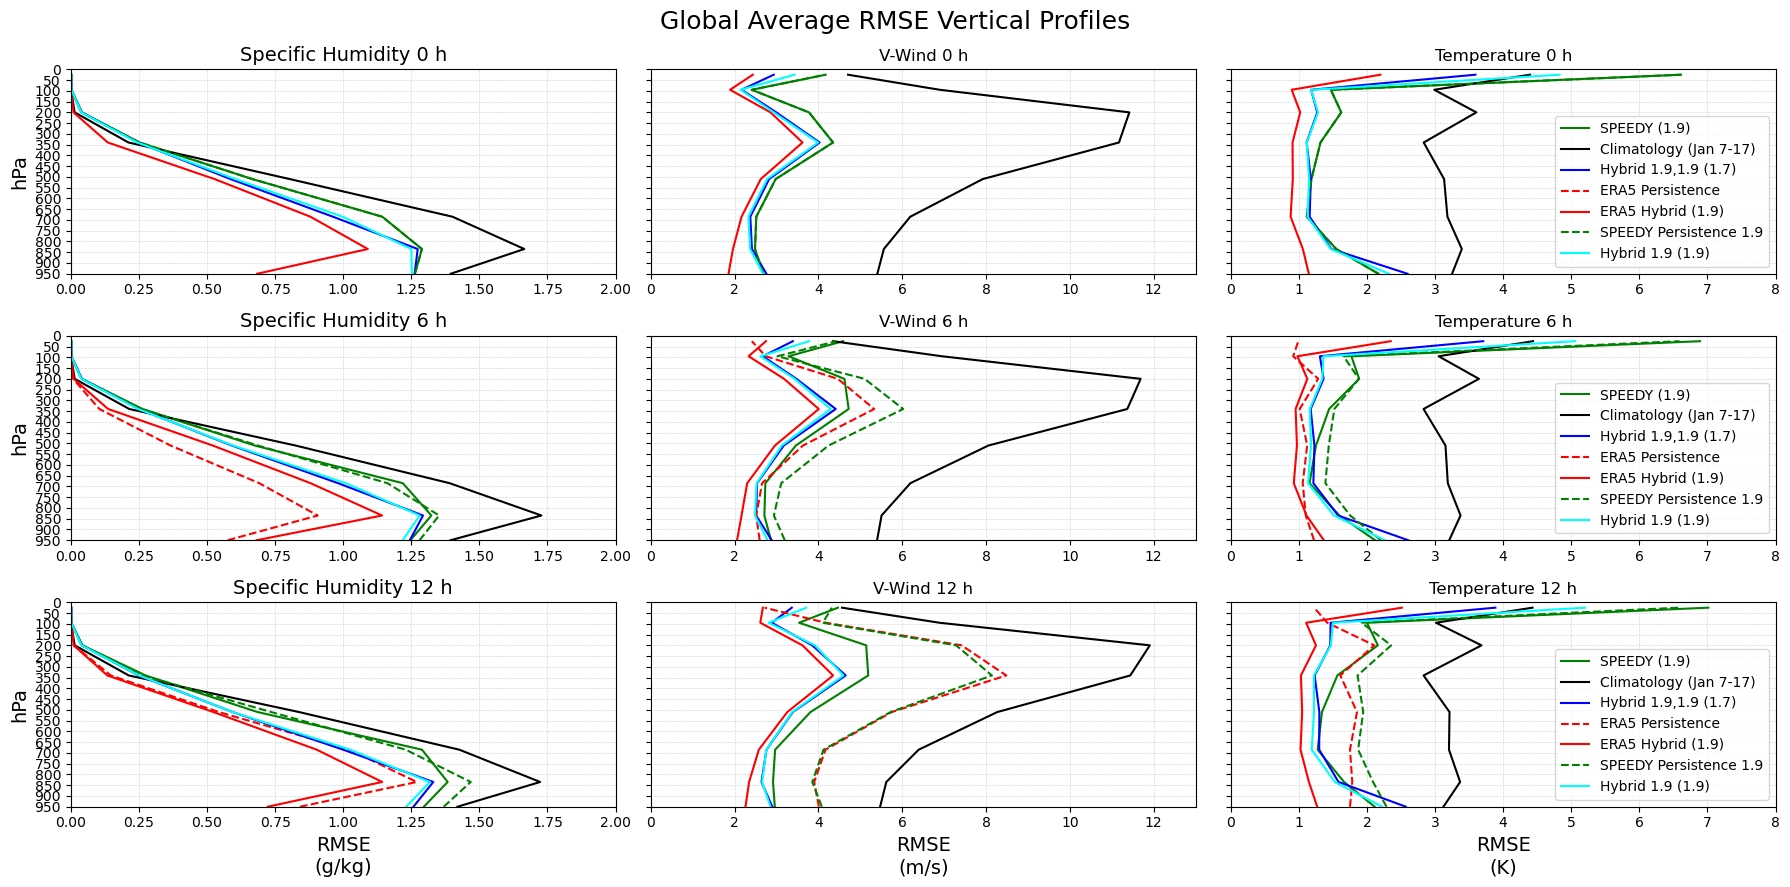

In [8]:
## make 3x3 error plot of 0, 6, 12 hr forecasts
# Assuming speedy_file_type_list_of_levels, average_list_hybrid_q, average_list_hybrid_v, average_list_hybrid_u, and average_list_hybrid_t are defined.

# Create subplots
number_of_rows = 3
number_of_columns = 3

fig, axs = plt.subplots(number_of_columns, number_of_rows, figsize=(18, 9), sharey=True)

# y-axis is height (in hPa)
y_axis = [1000 * i for i in speedy_file_type_list_of_levels]
# Invert y-axis
plt.gca().set_ylim(plt.gca().get_ylim()[::-1])

# Set y-ticks
plt.yticks(np.arange(0, 1000, 50))

i = 0
j = 0

# Set grid and labels
for j in range(number_of_columns):
    while i < number_of_rows:
        axs[i, j].grid(color='lightgrey', linestyle='--', linewidth=0.45)
        i += 1
    # reset i = 0 when exiting 1 iteration of the loop
    i = 0

fontsize_select = 14 
q_x_min = 0
q_x_max = 2

v_x_min = 0
v_x_max = 13

t_x_min = 0
t_x_max = 8

plt.suptitle('Global Average RMSE Vertical Profiles', fontsize=18)

# Plot for 'q'
# 0hr forecast
axs[0, 0].set_title('Specific Humidity 0 h', fontsize=fontsize_select)
axs[0, 0].plot(average_list_0hr_speedy_forecast_q_g_kg, y_axis, color='green')
axs[0, 0].plot(average_list_0hr_climate_forecast_q_g_kg, y_axis, color='black')
axs[0, 0].plot(average_list_0hr_persistence_forecast_q_g_kg, y_axis, color='red',linestyle='dashed')
axs[0, 0].plot(average_list_0hr_hybrid_forecast_q_g_kg, y_axis, color='blue')
axs[0, 0].plot(average_list_0hr_era5_trained_hybrid_forecast_q_g_kg, y_axis, color='red')
axs[0, 0].plot(average_list_0hr_speedy_persistence_forecast_q_g_kg, y_axis, color='green', linestyle='dashed')
# ADD 1st iter
axs[0, 0].plot(average_list_0hr_hybrid_1st_iter_forecast_q_g_kg, y_axis, color='cyan')
axs[0, 0].set_xlim(q_x_min, q_x_max)

# 6hr forecast
axs[1, 0].set_title('Specific Humidity 6 h', fontsize=fontsize_select)
axs[1, 0].plot(average_list_6hr_speedy_forecast_q_g_kg, y_axis, color='green')
axs[1, 0].plot(average_list_6hr_climate_forecast_q_g_kg, y_axis, color='black')
axs[1, 0].plot(average_list_6hr_persistence_forecast_q_g_kg, y_axis, color='red',linestyle='dashed')
axs[1, 0].plot(average_list_6hr_hybrid_forecast_q_g_kg, y_axis, color='blue')
axs[1, 0].plot(average_list_6hr_era5_trained_hybrid_forecast_q_g_kg, y_axis, color='red')
axs[1, 0].plot(average_list_6hr_speedy_persistence_forecast_q_g_kg, y_axis, color='green', linestyle='dashed')
axs[1, 0].plot(average_list_6hr_hybrid_1st_iter_forecast_q_g_kg, y_axis, color='cyan')
axs[1, 0].set_xlim(q_x_min, q_x_max)

# 12hr forecast
axs[2, 0].set_title('Specific Humidity 12 h', fontsize=fontsize_select)
axs[2, 0].plot(average_list_12hr_speedy_forecast_q_g_kg, y_axis, color='green')
axs[2, 0].plot(average_list_12hr_climate_forecast_q_g_kg, y_axis, color='black')
axs[2, 0].plot(average_list_12hr_persistence_forecast_q_g_kg, y_axis, color='red',linestyle='dashed')
axs[2, 0].plot(average_list_12hr_hybrid_forecast_q_g_kg, y_axis, color='blue')
axs[2, 0].plot(average_list_12hr_era5_trained_hybrid_forecast_q_g_kg, y_axis, color='red')
axs[2, 0].plot(average_list_12hr_speedy_persistence_forecast_q_g_kg, y_axis, color='green', linestyle='dashed')
axs[2, 0].plot(average_list_12hr_hybrid_1st_iter_forecast_q_g_kg, y_axis, color='cyan')
axs[2, 0].set_xlim(q_x_min, q_x_max)

axs[2, 0].set_xlabel('RMSE\n(g/kg)', fontsize=fontsize_select)
axs[0, 0].set_ylabel('hPa', fontsize=fontsize_select)
axs[1, 0].set_ylabel('hPa', fontsize=fontsize_select)
axs[2, 0].set_ylabel('hPa', fontsize=fontsize_select)

# Plot for 'v'
# 0hr forecast
axs[0, 1].set_title('V-Wind 0 h')
axs[0, 1].plot(average_list_0hr_speedy_forecast_v, y_axis, color='green')
axs[0, 1].plot(average_list_0hr_climate_forecast_v, y_axis, color='black')
axs[0, 1].plot(average_list_0hr_hybrid_forecast_v, y_axis, color='blue')
axs[0, 1].plot(average_list_0hr_persistence_forecast_v, y_axis, color='red',linestyle='dashed')
axs[0, 1].plot(average_list_0hr_trained_on_era5_hybrid_forecast_v, y_axis, color='red')
axs[0, 1].plot(average_list_0hr_speedy_persistence_forecast_v, y_axis, color='green', linestyle='dashed')
axs[0, 1].plot(average_list_0hr_hybrid_1st_iter_forecast_v, y_axis, color='cyan')
axs[0, 1].set_xlim(v_x_min, v_x_max)

# 6hr forecast
axs[1, 1].set_title('V-Wind 6 h')
axs[1, 1].plot(average_list_6hr_speedy_forecast_v, y_axis, color='green')
axs[1, 1].plot(average_list_6hr_climate_forecast_v, y_axis, color='black')
axs[1, 1].plot(average_list_6hr_hybrid_forecast_v, y_axis, color='blue')
axs[1, 1].plot(average_list_6hr_persistence_forecast_v, y_axis, color='red',linestyle='dashed')
axs[1, 1].plot(average_list_6hr_trained_on_era5_hybrid_forecast_v, y_axis, color='red')
axs[1, 1].plot(average_list_6hr_speedy_persistence_forecast_v, y_axis, color='green', linestyle='dashed')
axs[1, 1].plot(average_list_6hr_hybrid_1st_iter_forecast_v, y_axis, color='cyan')
axs[1, 1].set_xlim(v_x_min, v_x_max)

# 12hr forecast
axs[2, 1].set_title('V-Wind 12 h')
axs[2, 1].plot(average_list_12hr_speedy_forecast_v, y_axis, color='green')
axs[2, 1].plot(average_list_12hr_climate_forecast_v, y_axis, color='black')
axs[2, 1].plot(average_list_12hr_hybrid_forecast_v, y_axis, color='blue')
axs[2, 1].plot(average_list_12hr_persistence_forecast_v, y_axis, color='red',linestyle='dashed')
axs[2, 1].plot(average_list_12hr_trained_on_era5_hybrid_forecast_v, y_axis, color='red')
axs[2, 1].plot(average_list_12hr_speedy_persistence_forecast_v, y_axis, color='green', linestyle='dashed')
axs[2, 1].plot(average_list_12hr_hybrid_1st_iter_forecast_v, y_axis, color='cyan')
axs[2, 1].set_xlim(v_x_min, v_x_max)

axs[2, 1].set_xlabel('RMSE\n(m/s)', fontsize=fontsize_select)

# Plot for 't'
# 0hr forecast
axs[0, 2].set_title('Temperature 0 h')
axs[0, 2].plot(average_list_0hr_speedy_forecast_t, y_axis, color='green', label='SPEEDY (1.9)')
axs[0, 2].plot(average_list_0hr_climate_forecast_t, y_axis, color='black', label='Climatology (Jan 7-17)')
axs[0, 2].plot(average_list_0hr_hybrid_forecast_t, y_axis, color='blue', label='Hybrid 1.9,1.9 (1.7)')
axs[0, 2].plot(average_list_0hr_persistence_forecast_t, y_axis, color='red', linestyle='dashed',label='ERA5 Persistence')
axs[0, 2].plot(average_list_0hr_trained_on_era5_hybrid_forecast_t, y_axis, color='red',label='ERA5 Hybrid (1.9)')
axs[0, 2].plot(average_list_0hr_speedy_persistence_forecast_t, y_axis, color='green', linestyle='dashed',label='SPEEDY Persistence 1.9')
axs[0, 2].plot(average_list_0hr_hybrid_1st_iter_forecast_t, y_axis, color='cyan', label='Hybrid 1.9 (1.9)')
axs[0, 2].set_xlim(t_x_min, t_x_max)

# 6hr forecast
axs[1, 2].set_title('Temperature 6 h')
axs[1, 2].plot(average_list_6hr_speedy_forecast_t, y_axis, color='green', label='SPEEDY (1.9)')
axs[1, 2].plot(average_list_6hr_climate_forecast_t, y_axis, color='black', label='Climatology (Jan 7-17)')
axs[1, 2].plot(average_list_6hr_hybrid_forecast_t, y_axis, color='blue', label='Hybrid 1.9,1.9 (1.7)')
axs[1, 2].plot(average_list_6hr_persistence_forecast_t, y_axis, color='red', label='ERA5 Persistence',linestyle='dashed')
axs[1, 2].plot(average_list_6hr_trained_on_era5_hybrid_forecast_t, y_axis, color='red',label='ERA5 Hybrid (1.9)')
axs[1, 2].plot(average_list_6hr_speedy_persistence_forecast_t, y_axis, color='green', linestyle='dashed',label='SPEEDY Persistence 1.9')
axs[1, 2].plot(average_list_6hr_hybrid_1st_iter_forecast_t, y_axis, color='cyan', label='Hybrid 1.9 (1.9)')
axs[1, 2].set_xlim(t_x_min, t_x_max)

# 12hr forecast
axs[2, 2].set_title('Temperature 12 h')
axs[2, 2].plot(average_list_12hr_speedy_forecast_t, y_axis, color='green', label='SPEEDY (1.9)')
axs[2, 2].plot(average_list_12hr_climate_forecast_t, y_axis, color='black', label='Climatology (Jan 7-17)')
axs[2, 2].plot(average_list_12hr_hybrid_forecast_t, y_axis, color='blue', label='Hybrid 1.9,1.9 (1.7)')
axs[2, 2].plot(average_list_12hr_persistence_forecast_t, y_axis, color='red', label='ERA5 Persistence',linestyle='dashed')
axs[2, 2].plot(average_list_12hr_trained_on_era5_hybrid_forecast_t, y_axis, color='red',label='ERA5 Hybrid (1.9)')
axs[2, 2].plot(average_list_12hr_speedy_persistence_forecast_t, y_axis, color='green', linestyle='dashed',label='SPEEDY Persistence 1.9')
axs[2, 2].plot(average_list_12hr_hybrid_1st_iter_forecast_t, y_axis, color='cyan', label='Hybrid 1.9 (1.9)')
axs[2, 2].set_xlim(t_x_min, t_x_max)
axs[2, 2].set_xlabel('RMSE\n(K)', fontsize=fontsize_select)

for i in range(3):
    axs[i, 2].legend()

# Adjust layout
plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
#plt.savefig('forecast_plots/include_1st_iter_hybrid_1_9_1_9/FORECASTS_0hr_6hr_12hr_Global_RMSE_Vertical_Profiles_8_15_24.png',bbox_inches='tight', dpi=1200)
plt.show()


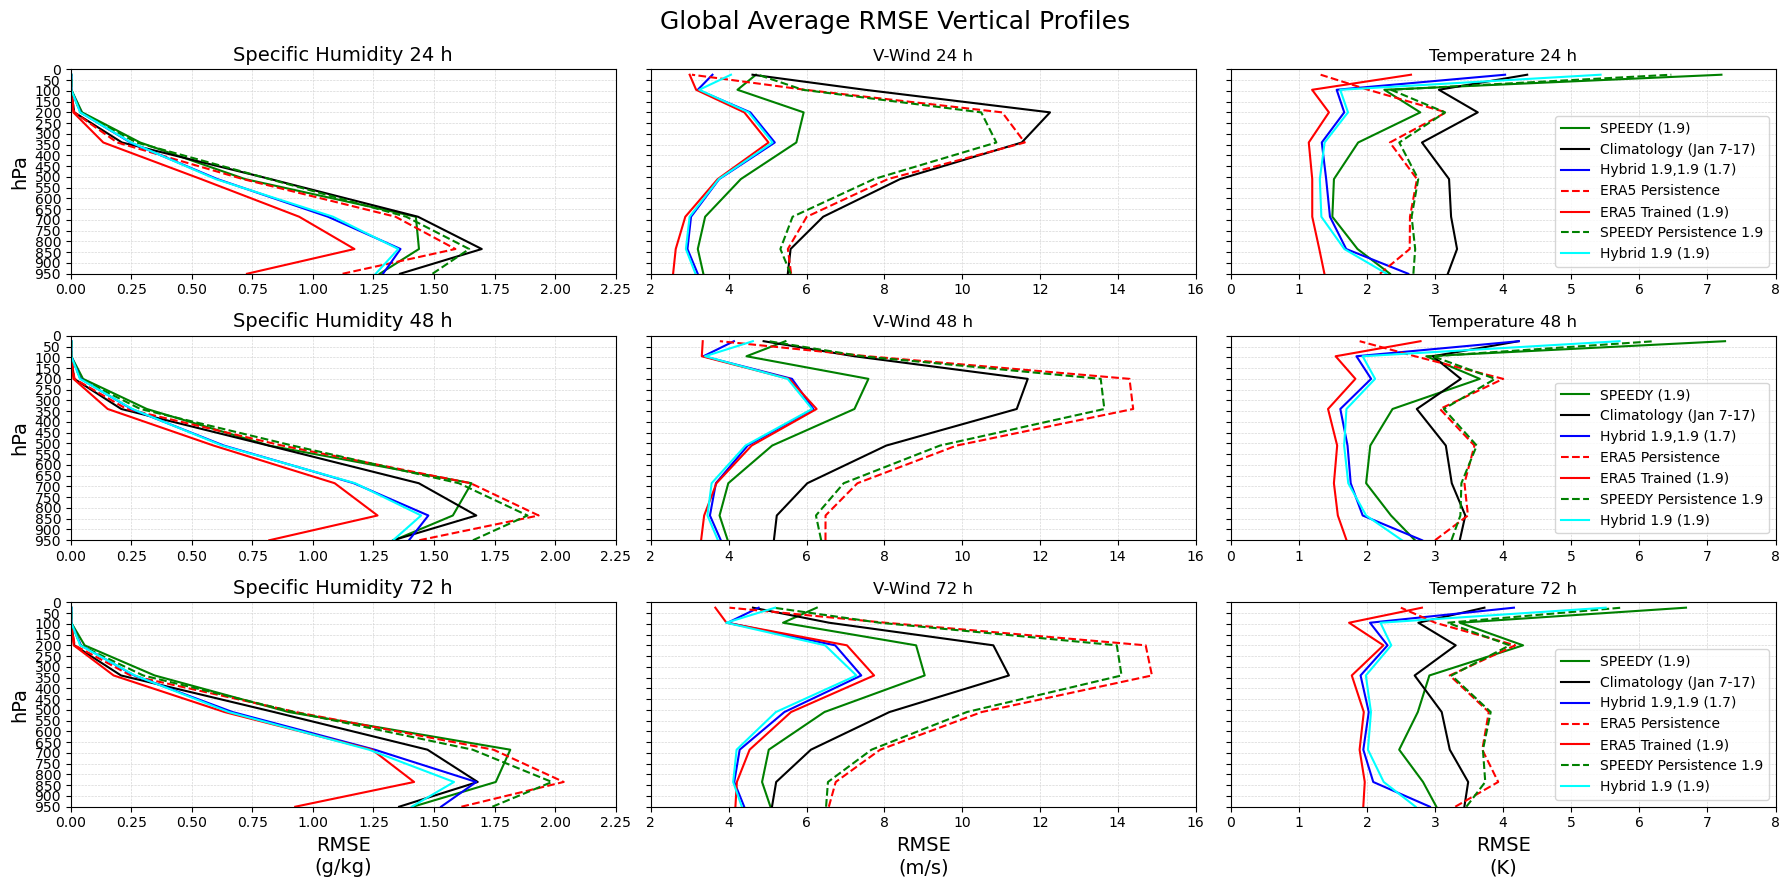

In [9]:
# PLOT FORECASTS - 24 hr, 48 hr, 72 hr together

# Assuming speedy_file_type_list_of_levels, average_list_hybrid_q, average_list_hybrid_v, average_list_hybrid_u, and average_list_hybrid_t are defined.

# Create subplots
number_of_rows = 3

number_of_columns = 3

fig, axs = plt.subplots(number_of_columns, number_of_rows, figsize=(18, 9), sharey=True)

# y-axis is height (in hPa)
y_axis = [1000 * i for i in speedy_file_type_list_of_levels]
# plt.gca().invert_y_axis()
plt.gca().set_ylim(plt.gca().get_ylim()[::-1])


# Set y-ticks
plt.yticks(np.arange(0, 1000, 50))
i = 0
j = 0
# for i in range(0,4,1):
for j in range(0,number_of_columns):
    while i < number_of_rows:

        axs[i,j].grid(color='lightgrey', linestyle='--', linewidth=0.45)
        i += 1
    # reset i = 0 when exit 1 iteration of loop    
    i = 0
    
fontsize_select = 14 
q_x_min=0
q_x_max=2.25

v_x_min = 2
v_x_max = 16

t_x_min = 0
t_x_max = 8

plt.suptitle('Global Average RMSE Vertical Profiles',fontsize=18)

# Plot for 'q'
# 24h forecast
axs[0,0].set_title('Specific Humidity 24 h',fontsize = fontsize_select)
axs[0,0].plot(average_list_24hr_speedy_forecast_q_g_kg, y_axis, color='green')
axs[0,0].plot(average_list_24hr_climate_forecast_q_g_kg,y_axis, color = 'black')
axs[0,0].plot(average_list_24hr_persistence_forecast_q_g_kg,y_axis, color = 'red',linestyle='dashed')
axs[0,0].plot(average_list_24hr_hybrid_forecast_q_g_kg,y_axis, color = 'blue')
axs[0,0].plot(average_list_24hr_era5_trained_hybrid_forecast_q_g_kg, y_axis, color='red')
axs[0,0].plot(average_list_24hr_speedy_persistence_forecast_q_g_kg, y_axis, color='green', linestyle='dashed')
axs[0,0].plot(average_list_24hr_hybrid_1st_iter_forecast_q_g_kg, y_axis, color='cyan')
axs[0,0].set_xlim(q_x_min, q_x_max)

#48 hr forecast
axs[1,0].set_title('Specific Humidity 48 h',fontsize = fontsize_select)
axs[1,0].plot(average_list_48hr_speedy_forecast_q_g_kg, y_axis, color='green')
axs[1,0].plot(average_list_48hr_climate_forecast_q_g_kg,y_axis, color = 'black')
axs[1,0].plot(average_list_48hr_persistence_forecast_q_g_kg,y_axis, color = 'red',linestyle='dashed')
axs[1,0].plot(average_list_48hr_hybrid_forecast_q_g_kg,y_axis, color = 'blue')
axs[1,0].plot(average_list_48hr_era5_trained_hybrid_forecast_q_g_kg, y_axis, color='red')
axs[1,0].plot(average_list_48hr_speedy_persistence_forecast_q_g_kg, y_axis, color='green', linestyle='dashed')
axs[1,0].plot(average_list_48hr_hybrid_1st_iter_forecast_q_g_kg, y_axis, color='cyan')
axs[1,0].set_xlim(q_x_min, q_x_max)

#72 hr forecast
axs[2,0].set_title('Specific Humidity 72 h',fontsize = fontsize_select)
axs[2,0].plot(average_list_72hr_speedy_forecast_q_g_kg, y_axis, color='green')
axs[2,0].plot(average_list_72hr_climate_forecast_q_g_kg,y_axis, color = 'black')
axs[2,0].plot(average_list_72hr_persistence_forecast_q_g_kg,y_axis, color = 'red',linestyle='dashed')
axs[2,0].plot(average_list_72hr_hybrid_forecast_q_g_kg,y_axis, color = 'blue')
axs[2,0].plot(average_list_72hr_era5_trained_hybrid_forecast_q_g_kg, y_axis, color='red')
axs[2,0].plot(average_list_72hr_speedy_persistence_forecast_q_g_kg, y_axis, color='green', linestyle='dashed')
axs[2,0].plot(average_list_72hr_hybrid_1st_iter_forecast_q_g_kg, y_axis, color='cyan')
axs[2,0].set_xlim(q_x_min, q_x_max)

axs[2,0].set_xlabel('RMSE\n(g/kg)',fontsize = fontsize_select)

axs[0,0].set_ylabel('hPa',fontsize = fontsize_select)
axs[1,0].set_ylabel('hPa',fontsize = fontsize_select)
axs[2,0].set_ylabel('hPa',fontsize = fontsize_select)

# for ax in axs:
#     ax.tick_params(axis='y', labelsize=fontsize_select)  # Set the font size to 12

# Plot for 'v'
# 24 hr forecast
axs[0,1].set_title('V-Wind 24 h')
axs[0,1].plot(average_list_24hr_speedy_forecast_v,y_axis, color='green')
axs[0,1].plot(average_list_24hr_climate_forecast_v,y_axis,color = 'black')
axs[0,1].plot(average_list_24hr_hybrid_forecast_v, y_axis, color = 'blue')
axs[0,1].plot(average_list_24hr_persistence_forecast_v,y_axis, color = 'red',linestyle='dashed')
axs[0,1].plot(average_list_24hr_trained_on_era5_hybrid_forecast_v, y_axis, color='red')
axs[0,1].plot(average_list_24hr_speedy_persistence_forecast_v, y_axis, color='green', linestyle='dashed')
axs[0,1].plot(average_list_24hr_hybrid_1st_iter_forecast_v, y_axis, color='cyan')
axs[0,1].set_xlim(v_x_min, v_x_max)

# 48 hr forecast
axs[1,1].set_title('V-Wind 48 h')
axs[1,1].plot(average_list_48hr_speedy_forecast_v,y_axis, color='green')
axs[1,1].plot(average_list_48hr_climate_forecast_v,y_axis,color = 'black')
axs[1,1].plot(average_list_48hr_hybrid_forecast_v, y_axis, color = 'blue')
axs[1,1].plot(average_list_48hr_persistence_forecast_v,y_axis, color = 'red',linestyle='dashed')
axs[1,1].plot(average_list_48hr_trained_on_era5_hybrid_forecast_v, y_axis, color='red')
axs[1,1].plot(average_list_48hr_speedy_persistence_forecast_v, y_axis, color='green', linestyle='dashed')
axs[1,1].plot(average_list_48hr_hybrid_1st_iter_forecast_v, y_axis, color='cyan')
axs[1,1].set_xlim(v_x_min, v_x_max)

# 72 hr forecast
axs[2,1].set_title('V-Wind 72 h')
axs[2,1].plot(average_list_72hr_speedy_forecast_v,y_axis, color='green')
axs[2,1].plot(average_list_72hr_climate_forecast_v,y_axis,color = 'black')
axs[2,1].plot(average_list_72hr_hybrid_forecast_v, y_axis, color = 'blue')
axs[2,1].plot(average_list_72hr_persistence_forecast_v,y_axis, color = 'red',linestyle='dashed')
axs[2,1].plot(average_list_72hr_trained_on_era5_hybrid_forecast_v, y_axis, color='red')
axs[2,1].plot(average_list_72hr_speedy_persistence_forecast_v, y_axis, color='green', linestyle='dashed')
axs[2,1].plot(average_list_72hr_hybrid_1st_iter_forecast_v, y_axis, color='cyan')
axs[2,1].set_xlim(v_x_min, v_x_max)


axs[2,1].set_xlabel('RMSE\n(m/s)',fontsize = fontsize_select)

# for ax in axs:
#     ax.tick_params(axis='x', labelsize=fontsize_select)
    
# Plot for 't'
# 24 hr forecast
axs[0,2].set_title('Temperature 24 h')
axs[0,2].plot(average_list_24hr_speedy_forecast_t,y_axis, color='green',label= 'SPEEDY (1.9)')
axs[0,2].plot(average_list_24hr_climate_forecast_t,y_axis,color = 'black',label='Climatology (Jan 7-17)')
axs[0,2].plot(average_list_24hr_hybrid_forecast_t, y_axis, color = 'blue',label = 'Hybrid 1.9,1.9 (1.7)')
axs[0,2].plot(average_list_24hr_persistence_forecast_t,y_axis, color = 'red',label= 'ERA5 Persistence',linestyle='dashed')
axs[0,2].plot(average_list_24hr_trained_on_era5_hybrid_forecast_t, y_axis, color='red',label='ERA5 Trained (1.9)')
axs[0,2].plot(average_list_24hr_speedy_persistence_forecast_t, y_axis, color='green', linestyle='dashed',label='SPEEDY Persistence 1.9')
axs[0,2].plot(average_list_24hr_hybrid_1st_iter_forecast_t, y_axis, color='cyan', label='Hybrid 1.9 (1.9)')
axs[0,2].set_xlim(t_x_min, t_x_max)

# 48 hr forecast
axs[1,2].set_title('Temperature 48 h')
axs[1,2].plot(average_list_48hr_speedy_forecast_t,y_axis, color='green',label= 'SPEEDY (1.9)')
axs[1,2].plot(average_list_48hr_climate_forecast_t,y_axis,color = 'black',label='Climatology (Jan 7-17)')
axs[1,2].plot(average_list_48hr_hybrid_forecast_t, y_axis, color = 'blue',label = 'Hybrid 1.9,1.9 (1.7)')
axs[1,2].plot(average_list_48hr_persistence_forecast_t,y_axis, color = 'red',label= 'ERA5 Persistence',linestyle='dashed')
axs[1,2].plot(average_list_48hr_trained_on_era5_hybrid_forecast_t, y_axis, color='red',label='ERA5 Trained (1.9)')
axs[1,2].plot(average_list_48hr_speedy_persistence_forecast_t, y_axis, color='green', linestyle='dashed',label='SPEEDY Persistence 1.9')
axs[1,2].plot(average_list_48hr_hybrid_1st_iter_forecast_t, y_axis, color='cyan', label='Hybrid 1.9 (1.9)')
axs[1,2].set_xlim(t_x_min, t_x_max)

# 72 hr forecast
axs[2,2].set_title('Temperature 72 h')
axs[2,2].plot(average_list_72hr_speedy_forecast_t,y_axis, color='green',label= 'SPEEDY (1.9)')
axs[2,2].plot(average_list_72hr_climate_forecast_t,y_axis,color = 'black',label='Climatology (Jan 7-17)')
axs[2,2].plot(average_list_72hr_hybrid_forecast_t, y_axis, color = 'blue',label = 'Hybrid 1.9,1.9 (1.7)')
axs[2,2].plot(average_list_72hr_persistence_forecast_t,y_axis, color = 'red',label= 'ERA5 Persistence',linestyle='dashed')
axs[2,2].plot(average_list_72hr_trained_on_era5_hybrid_forecast_t, y_axis, color='red',label='ERA5 Trained (1.9)')
axs[2,2].plot(average_list_72hr_speedy_persistence_forecast_t, y_axis, color='green', linestyle='dashed',label='SPEEDY Persistence 1.9')
axs[2,2].plot(average_list_72hr_hybrid_1st_iter_forecast_t, y_axis, color='cyan', label='Hybrid 1.9 (1.9)')
axs[2,2].set_xlim(t_x_min, t_x_max)



for i in range(3):
    axs[i,2].legend() 


# axs[2].plot(average_list_hybrid_t, y_axis, color='red', label = "Speedy trained Hybrid 1.3,1.3")
# axs[2].plot(average_list_hybrid_2nditer_t, y_axis,color='green',label= 'Speedy trained Hybrid 1.3,1.3,1.3 (2nd Iteration)')


# axs[2].plot(average_list_hybrid_1_9_1_3_t,y_axis,color = 'purple',label='Speedy trained Hybrid 1.9,1.3')
# axs[2].plot(average_list_hybrid_1_9_1_9_t,y_axis,color = 'purple',linestyle = 'dashed',label='Speedy trained Hybrid 1.9,1.9')
# axs[2].plot(average_list_hybrid_1_9_2_2_t,y_axis,color = 'orange',linestyle = 'dashed',label='Speedy trained Hybrid 1.9,2.2')
# axs[2].plot(average_list_hybrid_1_9_1_5_t,y_axis,color = 'green',linestyle = 'dashed',label='Speedy trained Hybrid 1.9,1.5')

# axs[2].plot(average_list_speedy_t, y_axis, color='blue', label= 'Speedy 1.3')
# axs[2].plot(average_list_speedy_1_9_t, y_axis, color = 'blue', linestyle = 'dashed', label='Speedy 1.9')

# axs[2].plot(average_list_era5trained_t,y_axis,color='black',label = "ERA5 trained Hybrid 1.3")

axs[2,2].set_xlabel('RMSE\n(K)',fontsize = fontsize_select)

# for ax in axs:
#     ax.tick_params(axis='x', labelsize=fontsize_select)

# plt.legend()
# plt.legend(loc='upper center', bbox_to_anchor=(-.60, -0.1), fancybox=True, shadow=True, ncol=0, fontsize = 'large')

plt.subplots_adjust(wspace=0.01)
plt.tight_layout()
#plt.savefig('forecast_plots/include_1st_iter_hybrid_1_9_1_9/FORECASTS_Global_RMSE_24hr_48hr_72hr_Vertical_Profiles_8_15_24.png',bbox_inches='tight', dpi=1200)

plt.show()

In [ ]:
def create_plot_for_selected_hour(selected_hour):
    # Define the number of rows and columns for the subplots
    number_of_rows = 1
    number_of_columns = 3

    # Create subplots
    fig, axs = plt.subplots(number_of_rows, number_of_columns, figsize=(18, 6), sharey=True)

    # Handle the case where axs is not a 2D array
    if number_of_rows == 1 and number_of_columns == 1:
        axs = np.array([axs])
    elif number_of_rows == 1:
        axs = np.expand_dims(axs, 0)
    elif number_of_columns == 1:
        axs = np.expand_dims(axs, 1)

    # y-axis is height (in hPa)
    y_axis = [1000 * i for i in speedy_file_type_list_of_levels]
    plt.gca().set_ylim(plt.gca().get_ylim()[::-1])

    # Set y-ticks
    plt.yticks(np.arange(0, 1000, 50))
    i=0
    for j in range(0,number_of_columns):
        while i < number_of_rows:

            axs[i,j].grid(color='lightgrey', linestyle='--', linewidth=0.45)
            i += 1
        # reset i = 0 when exit 1 iteration of loop    
        i = 0
    q_x_min = 0
    q_x_max = 3

    v_x_min = 2
    v_x_max = 16

    t_x_min = 0
    t_x_max = 8
    
    # Data and x-axis limits for different forecast hours
    forecast_data = {
            0: {
        'q': (average_list_0hr_speedy_forecast_q_g_kg, average_list_0hr_climate_forecast_q_g_kg,
              average_list_0hr_persistence_forecast_q_g_kg, average_list_0hr_hybrid_forecast_q_g_kg, 
              average_list_0hr_era5_trained_hybrid_forecast_q_g_kg, average_list_0hr_speedy_persistence_forecast_q_g_kg,
              average_list_0hr_hybrid_1st_iter_forecast_q_g_kg),
        'v': (average_list_0hr_speedy_forecast_v, average_list_0hr_climate_forecast_v,
              average_list_0hr_persistence_forecast_v, average_list_0hr_hybrid_forecast_v,
              average_list_0hr_trained_on_era5_hybrid_forecast_v, average_list_0hr_speedy_persistence_forecast_v,
              average_list_0hr_hybrid_1st_iter_forecast_v),
        't': (average_list_0hr_speedy_forecast_t, average_list_0hr_climate_forecast_t,
              average_list_0hr_persistence_forecast_t, average_list_0hr_hybrid_forecast_t,
              average_list_0hr_trained_on_era5_hybrid_forecast_t, average_list_0hr_speedy_persistence_forecast_t,
              average_list_0hr_hybrid_1st_iter_forecast_t),
        'x_limits': {'q': (q_x_min, q_x_max), 'v': (v_x_min, v_x_max), 't': (t_x_min, t_x_max)}
    },
    6: {
        'q': (average_list_6hr_speedy_forecast_q_g_kg, average_list_6hr_climate_forecast_q_g_kg,
              average_list_6hr_persistence_forecast_q_g_kg, average_list_6hr_hybrid_forecast_q_g_kg,
              average_list_6hr_era5_trained_hybrid_forecast_q_g_kg, average_list_6hr_speedy_persistence_forecast_q_g_kg,
              average_list_6hr_hybrid_1st_iter_forecast_q_g_kg),
        'v': (average_list_6hr_speedy_forecast_v, average_list_6hr_climate_forecast_v,
              average_list_6hr_persistence_forecast_v, average_list_6hr_hybrid_forecast_v,
              average_list_6hr_trained_on_era5_hybrid_forecast_v, average_list_6hr_speedy_persistence_forecast_v,
              average_list_6hr_hybrid_1st_iter_forecast_v),
        't': (average_list_6hr_speedy_forecast_t, average_list_6hr_climate_forecast_t,
              average_list_6hr_persistence_forecast_t, average_list_6hr_hybrid_forecast_t,
              average_list_6hr_trained_on_era5_hybrid_forecast_t, average_list_6hr_speedy_persistence_forecast_t,
              average_list_6hr_hybrid_1st_iter_forecast_t),
        'x_limits': {'q': (q_x_min, q_x_max), 'v': (v_x_min, v_x_max), 't': (t_x_min, t_x_max)}
    },
    12: {
        'q': (average_list_12hr_speedy_forecast_q_g_kg, average_list_12hr_climate_forecast_q_g_kg,
              average_list_12hr_persistence_forecast_q_g_kg, average_list_12hr_hybrid_forecast_q_g_kg,
              average_list_12hr_era5_trained_hybrid_forecast_q_g_kg, average_list_12hr_speedy_persistence_forecast_q_g_kg,
              average_list_12hr_hybrid_1st_iter_forecast_q_g_kg),
        'v': (average_list_12hr_speedy_forecast_v, average_list_12hr_climate_forecast_v,
              average_list_12hr_persistence_forecast_v, average_list_12hr_hybrid_forecast_v,
              average_list_12hr_trained_on_era5_hybrid_forecast_v, average_list_12hr_speedy_persistence_forecast_v,
              average_list_12hr_hybrid_1st_iter_forecast_v),
        't': (average_list_12hr_speedy_forecast_t, average_list_12hr_climate_forecast_t,
              average_list_12hr_persistence_forecast_t, average_list_12hr_hybrid_forecast_t,
              average_list_12hr_trained_on_era5_hybrid_forecast_t, average_list_12hr_speedy_persistence_forecast_t,
              average_list_12hr_hybrid_1st_iter_forecast_t),
        'x_limits': {'q': (q_x_min, q_x_max), 'v': (v_x_min, v_x_max), 't': (t_x_min, t_x_max)}
    },
    18: {
        'q': (average_list_18hr_speedy_forecast_q_g_kg, average_list_18hr_climate_forecast_q_g_kg,
              average_list_18hr_persistence_forecast_q_g_kg, average_list_18hr_hybrid_forecast_q_g_kg,
              average_list_18hr_era5_trained_hybrid_forecast_q_g_kg, average_list_18hr_speedy_persistence_forecast_q_g_kg,
              average_list_18hr_hybrid_1st_iter_forecast_q_g_kg),
        'v': (average_list_18hr_speedy_forecast_v, average_list_18hr_climate_forecast_v,
              average_list_18hr_persistence_forecast_v, average_list_18hr_hybrid_forecast_v,
              average_list_18hr_trained_on_era5_hybrid_forecast_v, average_list_18hr_speedy_persistence_forecast_v,
              average_list_18hr_hybrid_1st_iter_forecast_v),
        't': (average_list_18hr_speedy_forecast_t, average_list_18hr_climate_forecast_t,
              average_list_18hr_persistence_forecast_t, average_list_18hr_hybrid_forecast_t,
              average_list_18hr_trained_on_era5_hybrid_forecast_t, average_list_18hr_speedy_persistence_forecast_t,
              average_list_18hr_hybrid_1st_iter_forecast_t),
        'x_limits': {'q': (q_x_min, q_x_max), 'v': (v_x_min, v_x_max), 't': (t_x_min, t_x_max)}
    },
        24: {
            'q': (average_list_24hr_speedy_forecast_q_g_kg, average_list_24hr_climate_forecast_q_g_kg,
                  average_list_24hr_persistence_forecast_q_g_kg, average_list_24hr_hybrid_forecast_q_g_kg, 
                  average_list_24hr_era5_trained_hybrid_forecast_q_g_kg, average_list_24hr_speedy_persistence_forecast_q_g_kg,
                  average_list_24hr_hybrid_1st_iter_forecast_q_g_kg),
            'v': (average_list_24hr_speedy_forecast_v, average_list_24hr_climate_forecast_v,
                  average_list_24hr_persistence_forecast_v, average_list_24hr_hybrid_forecast_v,
                 average_list_24hr_trained_on_era5_hybrid_forecast_v, average_list_24hr_speedy_persistence_forecast_v,
                 average_list_24hr_hybrid_1st_iter_forecast_v),
            't': (average_list_24hr_speedy_forecast_t, average_list_24hr_climate_forecast_t,
                  average_list_24hr_persistence_forecast_t, average_list_24hr_hybrid_forecast_t,
                 average_list_24hr_trained_on_era5_hybrid_forecast_t, average_list_24hr_speedy_persistence_forecast_t,
                 average_list_24hr_hybrid_1st_iter_forecast_t),
            'x_limits': {'q': (q_x_min, q_x_max), 'v': (v_x_min, v_x_max), 't': (t_x_min, t_x_max)}
        },
        48: {
            'q': (average_list_48hr_speedy_forecast_q_g_kg, average_list_48hr_climate_forecast_q_g_kg,
                  average_list_48hr_persistence_forecast_q_g_kg, average_list_48hr_hybrid_forecast_q_g_kg,
                 average_list_48hr_era5_trained_hybrid_forecast_q_g_kg, average_list_48hr_speedy_persistence_forecast_q_g_kg,
                 average_list_48hr_hybrid_1st_iter_forecast_q_g_kg),
            'v': (average_list_48hr_speedy_forecast_v, average_list_48hr_climate_forecast_v,
                  average_list_48hr_persistence_forecast_v, average_list_48hr_hybrid_forecast_v,
                  average_list_48hr_trained_on_era5_hybrid_forecast_v, average_list_48hr_speedy_persistence_forecast_v,
                 average_list_48hr_hybrid_1st_iter_forecast_v),
            't': (average_list_48hr_speedy_forecast_t, average_list_48hr_climate_forecast_t,
                  average_list_48hr_persistence_forecast_t, average_list_48hr_hybrid_forecast_t,
                  average_list_48hr_trained_on_era5_hybrid_forecast_t, average_list_48hr_speedy_persistence_forecast_t,
                 average_list_48hr_hybrid_1st_iter_forecast_t),
            'x_limits': {'q': (q_x_min, q_x_max), 'v': (v_x_min, v_x_max), 't': (t_x_min, t_x_max)}
        },
        72: {
            'q': (average_list_72hr_speedy_forecast_q_g_kg, average_list_72hr_climate_forecast_q_g_kg,
                  average_list_72hr_persistence_forecast_q_g_kg, average_list_72hr_hybrid_forecast_q_g_kg,
                 average_list_72hr_era5_trained_hybrid_forecast_q_g_kg, average_list_72hr_speedy_persistence_forecast_q_g_kg,
                 average_list_72hr_hybrid_1st_iter_forecast_q_g_kg),
            'v': (average_list_72hr_speedy_forecast_v, average_list_72hr_climate_forecast_v,
                  average_list_72hr_persistence_forecast_v, average_list_72hr_hybrid_forecast_v,
                 average_list_72hr_trained_on_era5_hybrid_forecast_v, average_list_72hr_speedy_persistence_forecast_v,
                 average_list_72hr_hybrid_1st_iter_forecast_v),
            't': (average_list_72hr_speedy_forecast_t, average_list_72hr_climate_forecast_t,
                  average_list_72hr_persistence_forecast_t, average_list_72hr_hybrid_forecast_t,
                 average_list_72hr_trained_on_era5_hybrid_forecast_t, average_list_72hr_speedy_persistence_forecast_t,
                 average_list_72hr_hybrid_1st_iter_forecast_t),
            'x_limits': {'q': (q_x_min, q_x_max), 'v': (v_x_min, v_x_max), 't': (t_x_min, t_x_max)}
        },
        120: {
            'q': (average_list_120hr_speedy_forecast_q_g_kg, average_list_120hr_climate_forecast_q_g_kg,
                  average_list_120hr_persistence_forecast_q_g_kg, average_list_120hr_hybrid_forecast_q_g_kg,
                 average_list_120hr_era5_trained_hybrid_forecast_q_g_kg, average_list_120hr_speedy_persistence_forecast_q_g_kg,
                 average_list_120hr_hybrid_1st_iter_forecast_q_g_kg),
            'v': (average_list_120hr_speedy_forecast_v, average_list_120hr_climate_forecast_v,
                  average_list_120hr_persistence_forecast_v, average_list_120hr_hybrid_forecast_v,
                 average_list_120hr_trained_on_era5_hybrid_forecast_v, average_list_120hr_speedy_persistence_forecast_v,
                 average_list_120hr_hybrid_1st_iter_forecast_v),
            't': (average_list_120hr_speedy_forecast_t, average_list_120hr_climate_forecast_t,
                  average_list_120hr_persistence_forecast_t, average_list_120hr_hybrid_forecast_t,
                 average_list_120hr_trained_on_era5_hybrid_forecast_t, average_list_120hr_speedy_persistence_forecast_t,
                 average_list_120hr_hybrid_1st_iter_forecast_t),
            'x_limits': {'q': (q_x_min, q_x_max), 'v': (v_x_min, v_x_max), 't': (t_x_min, t_x_max)}
        },
        240: {
            'q': (average_list_240hr_speedy_forecast_q_g_kg, average_list_240hr_climate_forecast_q_g_kg,
                  average_list_240hr_persistence_forecast_q_g_kg, average_list_240hr_hybrid_forecast_q_g_kg,
                 average_list_240hr_era5_trained_hybrid_forecast_q_g_kg, average_list_240hr_speedy_persistence_forecast_q_g_kg,
                 average_list_240hr_hybrid_1st_iter_forecast_q_g_kg),
            'v': (average_list_240hr_speedy_forecast_v, average_list_240hr_climate_forecast_v,
                  average_list_240hr_persistence_forecast_v, average_list_240hr_hybrid_forecast_v,
                 average_list_240hr_trained_on_era5_hybrid_forecast_v, average_list_240hr_speedy_persistence_forecast_v,
                 average_list_240hr_hybrid_1st_iter_forecast_v),
            't': (average_list_240hr_speedy_forecast_t, average_list_240hr_climate_forecast_t,
                  average_list_240hr_persistence_forecast_t, average_list_240hr_hybrid_forecast_t,
                 average_list_240hr_trained_on_era5_hybrid_forecast_t, average_list_240hr_speedy_persistence_forecast_t,
                 average_list_240hr_hybrid_1st_iter_forecast_t),
            'x_limits': {'q': (q_x_min, q_x_max), 'v': (v_x_min, v_x_max), 't': (t_x_min, t_x_max)}
        }
    }


    # Select data and limits based on selected_hour
    data = forecast_data.get(selected_hour)
    if not data:
        print(f"No data available for {selected_hour} hour forecast.")
        return

    q_data, v_data, t_data = data['q'], data['v'], data['t']
    q_x_min, q_x_max = data['x_limits']['q']
    v_x_min, v_x_max = data['x_limits']['v']
    t_x_min, t_x_max = data['x_limits']['t']

    # Plot for 'q' (Specific Humidity)
    axs[0,0].set_title(f'Specific Humidity {selected_hour} h', fontsize=14)
    axs[0,0].plot(q_data[0], y_axis, color='green', label='SPEEDY (1.9)')
    axs[0,0].plot(q_data[1], y_axis, color='black', label='Climatology (Jan 7-17)')
    axs[0,0].plot(q_data[2], y_axis, color='red', label='ERA5 Persistence', linestyle='dashed')
    axs[0,0].plot(q_data[3], y_axis, color='blue', label='Hybrid 1.9,1.9 (1.7)')
    axs[0,0].plot(q_data[4], y_axis, color='red', label='ERA5 Hybrid (1.9)')
    axs[0,0].plot(q_data[5], y_axis, color='green',label='SPEEDY Persistence 1.9', linestyle='dashed')
    axs[0,0].plot(q_data[6], y_axis, color='cyan',label='Hybrid 1.9 (1.9)')
    axs[0,0].set_xlim(q_x_min, q_x_max)
    axs[0,0].set_ylabel('hPa', fontsize=14)

    # Plot for 'v' (V-Wind)
    axs[0,1].set_title(f'V-Wind {selected_hour} h', fontsize=14)
    axs[0,1].plot(v_data[0], y_axis, color='green', label='SPEEDY (1.9)')
    axs[0,1].plot(v_data[1], y_axis, color='black', label='Climatology (Jan 7-17)')
    axs[0,1].plot(v_data[2], y_axis, color='red', label='ERA5 Persistence', linestyle='dashed')
    axs[0,1].plot(v_data[3], y_axis, color='blue', label='Hybrid 1.9,1.9 (1.7)')
    axs[0,1].plot(v_data[4], y_axis, color='red', label='ERA5 Hybrid (1.9)')
    axs[0,1].plot(v_data[5], y_axis, color='green',label='SPEEDY Persistence 1.9', linestyle='dashed')
    axs[0,1].plot(v_data[6], y_axis, color='cyan',label='Hybrid 1.9 (1.9)')
    axs[0,1].set_xlim(v_x_min, v_x_max)

    # Plot for 't' (Temperature)
    axs[0,2].set_title(f'Temperature {selected_hour} h', fontsize=14)
    axs[0,2].plot(t_data[0], y_axis, color='green', label='SPEEDY (1.9)')
    axs[0,2].plot(t_data[1], y_axis, color='black', label='Climatology (Jan 7-17)')
    axs[0,2].plot(t_data[2], y_axis, color='red', label='ERA5 Persistence', linestyle='dashed')
    axs[0,2].plot(t_data[3], y_axis, color='blue', label='Hybrid 1.9,1.9 (1.7)')
    axs[0,2].plot(t_data[4], y_axis, color='red', label='ERA5 Hybrid (1.9)')
    axs[0,2].plot(t_data[5], y_axis, color='green',label='SPEEDY Persistence 1.9', linestyle='dashed')
    axs[0,2].plot(t_data[6], y_axis, color='cyan',label='Hybrid 1.9 (1.9)')
    axs[0,2].set_xlim(t_x_min, t_x_max)

    # Adjust layout and show plot
    plt.suptitle(f'Global Average RMSE Vertical Profiles - {selected_hour} Hour Forecast', fontsize=18)
    
    
    # Set x-labels
    axs[0,0].set_xlabel('RMSE\n(g/kg)', fontsize=fontsize_select)
    axs[0,1].set_xlabel('RMSE\n(m/s)', fontsize=fontsize_select)
    axs[0,2].set_xlabel('RMSE\n(K)', fontsize=fontsize_select)

    # Add legends
    for ax in axs.flat:
        ax.legend(loc='best')

    plt.subplots_adjust(wspace=0.3)
    plt.tight_layout()
#     if t == 120 or t == 240:
    #plt.savefig(f'forecast_plots/include_1st_iter_hybrid_1_9_1_9/FORECASTS_Global_RMSE_{t}hr_Vertical_Profile_8_15_24.png',bbox_inches='tight', dpi=1200)
    plt.show()


In [ ]:
for t in time_period_list:
    create_plot_for_selected_hour(t)